In [1]:
from __future__ import print_function
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import IPython.display as ipd
import seaborn as sns

import warnings
import os
warnings.filterwarnings('ignore')

from torch import nn, optim
from torchvision import transforms, models, datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
pwd

'/root/autodl-tmp/SER/speech-emotion-recognition-iemocap-master/code/models'

In [3]:
data_dir = '/root/autodl-tmp/SER/speech-emotion-recognition-iemocap-master/SER_new/IEMOCAP_image_data'
model_save_path = '/root/autodl-tmp/SER/speech-emotion-recognition-iemocap-master/SER_new/saved_models'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [4]:
batch_size = 64

In [5]:
train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
test_transforms = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [6]:
trainset = datasets.ImageFolder(train_dir,transform=train_transforms)
testset = datasets.ImageFolder(test_dir,transform=test_transforms)

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [8]:
print(len(testloader.dataset))

880


In [9]:
print(len(trainloader.dataset))

3610


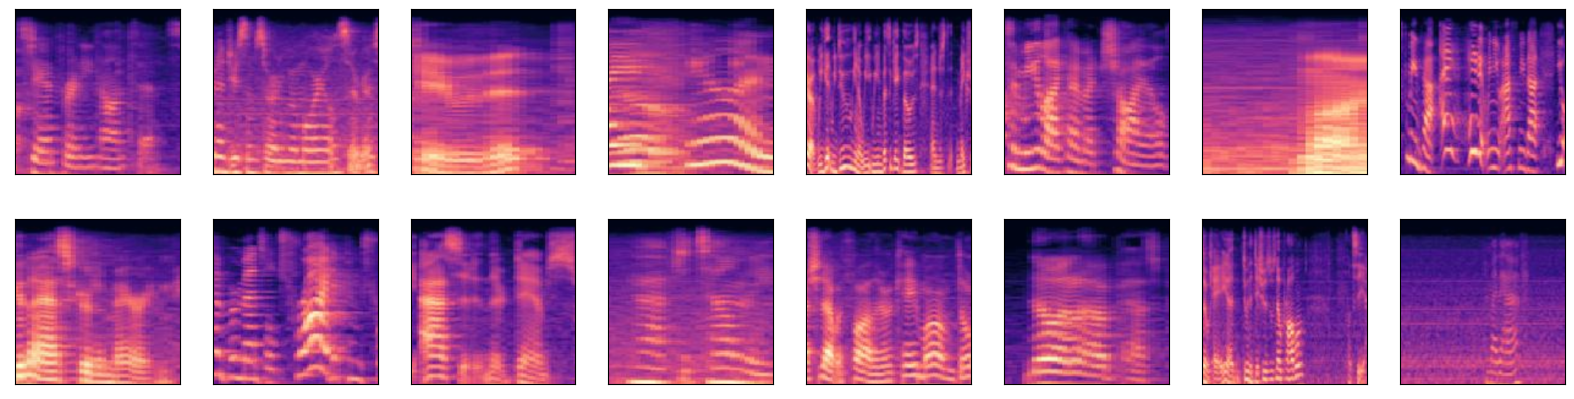

In [10]:
# def scale(x, out_range=(-1, 1)):
#     domain = np.min(x), np.max(x)
#     y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
#     return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

import numpy as np
import matplotlib.pyplot as plt

# scale 函数将数组归一化到 0 和 1 之间
def scale(x):
    return (x - np.min(x)) / np.ptp(x)

# imshow 函数用于显示图像
def imshow(img):
    img = scale(img)  # 将图像缩放到 [0, 1] 范围内，便于可视化
    plt.imshow(np.transpose(img, (1, 2, 0)))  # 调整通道顺序以匹配 Matplotlib 的显示格式

# 获取一个批次的数据
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()  # 将图像张量转换为 numpy 数组，方便可视化处理

# 创建图像的显示窗口
fig = plt.figure(figsize=(20, 5))

# 循环显示 16 张图像
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16 // 2, idx + 1, xticks=[], yticks=[])  # 使用整数除法，确保列数为整数
    imshow(images[idx])  # 调用 imshow 函数显示图像

plt.show()  # 显示所有图像

In [11]:
trainiter = iter(trainloader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [12]:
torch.cuda.is_available()

True

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
model = models.resnet152(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [15:20<00:00, 263kB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
for param in model.parameters():
    param.requires_grad = False

In [16]:
# 更新 classifier，使其匹配 ResNet50 的输出
classifier = nn.Sequential(
    nn.Linear(2048, 200),  # 将输入调整为 2048 以匹配 ResNet50 的输出
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 4)      # 输出类别数为 4
)
model.fc = classifier

In [17]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
# print(trainloader.dataset.classes)
print(trainloader.dataset.class_to_idx)

{'anger': 0, 'happiness': 1, 'neutral': 2, 'sadness': 3}


In [19]:
anger = 0
happiness = 0
neutral = 0
sadness = 0

for _, target in trainloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])
    
for _, target in testloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])

In [20]:
print("anger {} happiness {} neutral {} sadness {}".format(anger, happiness, neutral, sadness))

anger 1103 happiness 595 neutral 1708 sadness 1084


In [21]:
sample_weights = [1/anger, 1/happiness, 1/neutral, 1/sadness]
class_weights = torch.FloatTensor(sample_weights).cuda()
class_weights

tensor([0.0009, 0.0017, 0.0006, 0.0009], device='cuda:0')

In [22]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [23]:
# optimizer = optim.RMSprop(model.parameters(), lr=0.0003)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
model = model.to(device)

In [24]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

58,554,412 total parameters.
410,604 training parameters.


In [25]:
labels = list(trainloader.dataset.class_to_idx.keys())
labels

['anger', 'happiness', 'neutral', 'sadness']

In [26]:
def plot_confusion_matrix(actual, predicted, labels):
    cm = confusion_matrix(actual, predicted, labels=labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, annot_kws={"size": 10}, fmt='.0f'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    plt.show()

In [27]:
label_to_class = {value: key for key, value in trainloader.dataset.class_to_idx.items()}
label_to_class

{0: 'anger', 1: 'happiness', 2: 'neutral', 3: 'sadness'}

In [28]:
def train(epoch, model):
    model.train()
    correct_train = 0
    train_loss = 0
    train_acc = 0
    
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        # zero the gradient, forward, backward and running pytorch rhythm
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct_train += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    
    train_loss /= len(trainloader.dataset)
    train_acc = 100. * correct_train / len(trainloader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(train_loss))
    print('\nTrain Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct_train, len(trainloader.dataset), 100. * correct_train / len(trainloader.dataset)))
    
    return train_loss, int(train_acc.numpy())
            

In [29]:
def test(model):
    model.eval()
    test_loss = 0
    test_acc = 0
    correct = 0
    history_test = []

    pred_model = []
    actual = []

    for data, target in testloader:
        data, target = data.to(device), target.to(device)

        # output from model
        output = model(data)

        # sum total loss
        test_loss += criterion(output, target).item()

        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        pred_model.append(pred.cpu().numpy())
        actual.append(target.data.cpu().numpy())


    test_loss /= len(testloader.dataset)
    test_acc = 100. * correct / len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


    pred_with_label = [label_to_class[label] for label in list(np.concatenate(pred_model))]
    actual_with_label = [label_to_class[label] for label in list(np.concatenate(actual))]

    plot_confusion_matrix(actual_with_label, pred_with_label, labels)

    print('\n Classification Report \n {} \n'.format(classification_report(actual_with_label, pred_with_label)))

    return test_loss, int(test_acc.numpy())

Train Epoch: 1 [0/3610 (0%)]	Loss: 1.423620

Train Epoch: 1 [640/3610 (18%)]	Loss: 1.410849

Train Epoch: 1 [1280/3610 (35%)]	Loss: 1.387087

Train Epoch: 1 [1920/3610 (53%)]	Loss: 1.394604

Train Epoch: 1 [2560/3610 (70%)]	Loss: 1.361198

Train Epoch: 1 [3200/3610 (88%)]	Loss: 1.379153


Train set: Average loss: 0.0218


Train Accuracy: 1064/3610 (29%)


Test set: Average loss: 0.0219, Accuracy: 164/880 (19%)



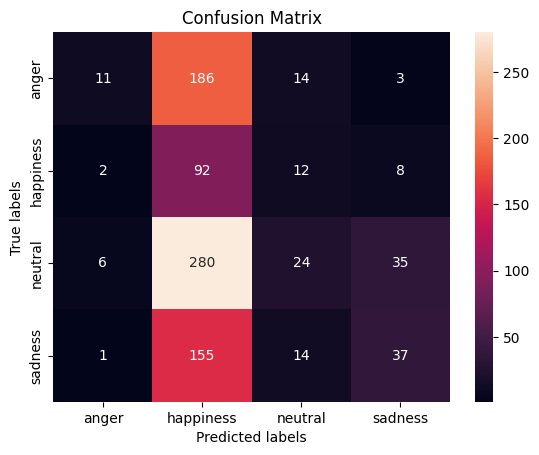


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.05      0.09       214
   happiness       0.13      0.81      0.22       114
     neutral       0.38      0.07      0.12       345
     sadness       0.45      0.18      0.26       207

    accuracy                           0.19       880
   macro avg       0.37      0.28      0.17       880
weighted avg       0.40      0.19      0.16       880
 

Train Epoch: 2 [0/3610 (0%)]	Loss: 1.359821

Train Epoch: 2 [640/3610 (18%)]	Loss: 1.338109

Train Epoch: 2 [1280/3610 (35%)]	Loss: 1.347596

Train Epoch: 2 [1920/3610 (53%)]	Loss: 1.379042

Train Epoch: 2 [2560/3610 (70%)]	Loss: 1.379105

Train Epoch: 2 [3200/3610 (88%)]	Loss: 1.359918


Train set: Average loss: 0.0212


Train Accuracy: 1260/3610 (35%)


Test set: Average loss: 0.0209, Accuracy: 437/880 (50%)



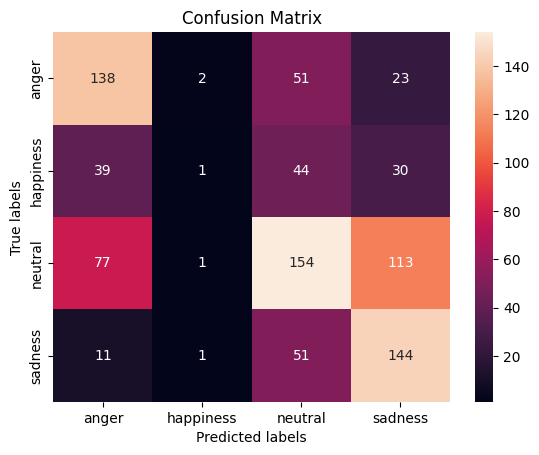


 Classification Report 
               precision    recall  f1-score   support

       anger       0.52      0.64      0.58       214
   happiness       0.20      0.01      0.02       114
     neutral       0.51      0.45      0.48       345
     sadness       0.46      0.70      0.56       207

    accuracy                           0.50       880
   macro avg       0.42      0.45      0.41       880
weighted avg       0.46      0.50      0.46       880
 

Train Epoch: 3 [0/3610 (0%)]	Loss: 1.327932

Train Epoch: 3 [640/3610 (18%)]	Loss: 1.360265

Train Epoch: 3 [1280/3610 (35%)]	Loss: 1.306192

Train Epoch: 3 [1920/3610 (53%)]	Loss: 1.315960

Train Epoch: 3 [2560/3610 (70%)]	Loss: 1.300763

Train Epoch: 3 [3200/3610 (88%)]	Loss: 1.294348


Train set: Average loss: 0.0208


Train Accuracy: 1494/3610 (41%)


Test set: Average loss: 0.0208, Accuracy: 372/880 (42%)



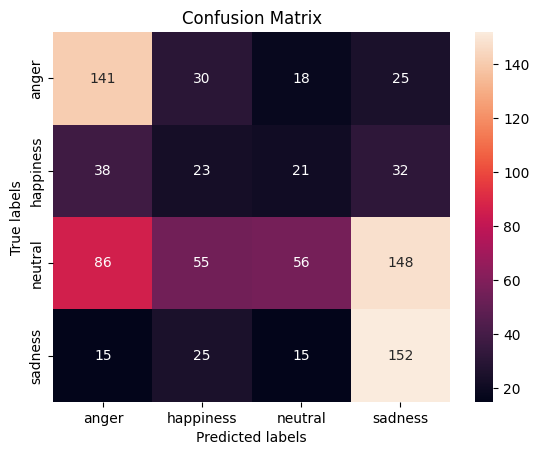


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.66      0.57       214
   happiness       0.17      0.20      0.19       114
     neutral       0.51      0.16      0.25       345
     sadness       0.43      0.73      0.54       207

    accuracy                           0.42       880
   macro avg       0.40      0.44      0.39       880
weighted avg       0.44      0.42      0.39       880
 

Train Epoch: 4 [0/3610 (0%)]	Loss: 1.274215

Train Epoch: 4 [640/3610 (18%)]	Loss: 1.305249

Train Epoch: 4 [1280/3610 (35%)]	Loss: 1.311511

Train Epoch: 4 [1920/3610 (53%)]	Loss: 1.306204

Train Epoch: 4 [2560/3610 (70%)]	Loss: 1.237628

Train Epoch: 4 [3200/3610 (88%)]	Loss: 1.352947


Train set: Average loss: 0.0203


Train Accuracy: 1521/3610 (42%)


Test set: Average loss: 0.0201, Accuracy: 465/880 (53%)



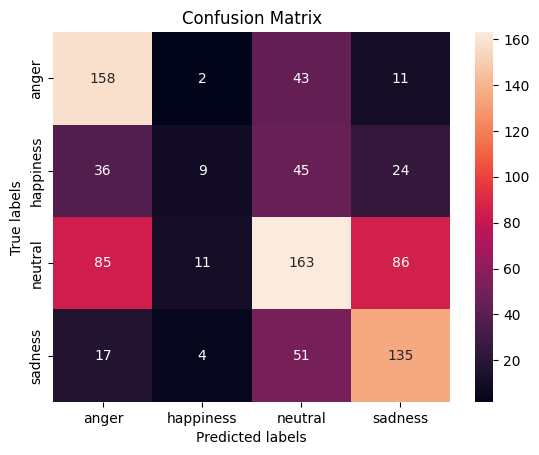


 Classification Report 
               precision    recall  f1-score   support

       anger       0.53      0.74      0.62       214
   happiness       0.35      0.08      0.13       114
     neutral       0.54      0.47      0.50       345
     sadness       0.53      0.65      0.58       207

    accuracy                           0.53       880
   macro avg       0.49      0.49      0.46       880
weighted avg       0.51      0.53      0.50       880
 

Train Epoch: 5 [0/3610 (0%)]	Loss: 1.284933

Train Epoch: 5 [640/3610 (18%)]	Loss: 1.259606

Train Epoch: 5 [1280/3610 (35%)]	Loss: 1.289081

Train Epoch: 5 [1920/3610 (53%)]	Loss: 1.299984

Train Epoch: 5 [2560/3610 (70%)]	Loss: 1.298906

Train Epoch: 5 [3200/3610 (88%)]	Loss: 1.209352


Train set: Average loss: 0.0199


Train Accuracy: 1662/3610 (46%)


Test set: Average loss: 0.0199, Accuracy: 427/880 (49%)



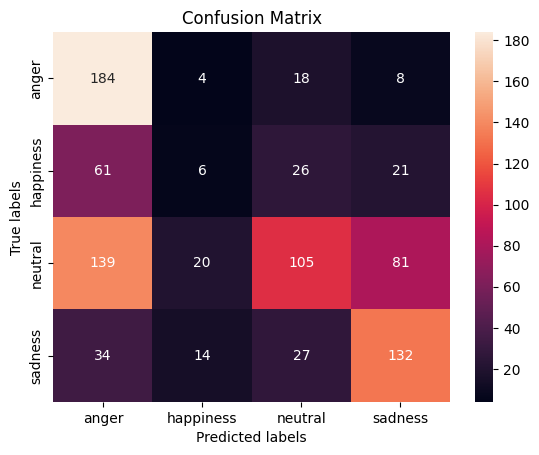


 Classification Report 
               precision    recall  f1-score   support

       anger       0.44      0.86      0.58       214
   happiness       0.14      0.05      0.08       114
     neutral       0.60      0.30      0.40       345
     sadness       0.55      0.64      0.59       207

    accuracy                           0.49       880
   macro avg       0.43      0.46      0.41       880
weighted avg       0.49      0.49      0.45       880
 

Train Epoch: 6 [0/3610 (0%)]	Loss: 1.288776

Train Epoch: 6 [640/3610 (18%)]	Loss: 1.189474

Train Epoch: 6 [1280/3610 (35%)]	Loss: 1.327816

Train Epoch: 6 [1920/3610 (53%)]	Loss: 1.165365

Train Epoch: 6 [2560/3610 (70%)]	Loss: 1.313165

Train Epoch: 6 [3200/3610 (88%)]	Loss: 1.247996


Train set: Average loss: 0.0196


Train Accuracy: 1725/3610 (48%)


Test set: Average loss: 0.0195, Accuracy: 463/880 (53%)



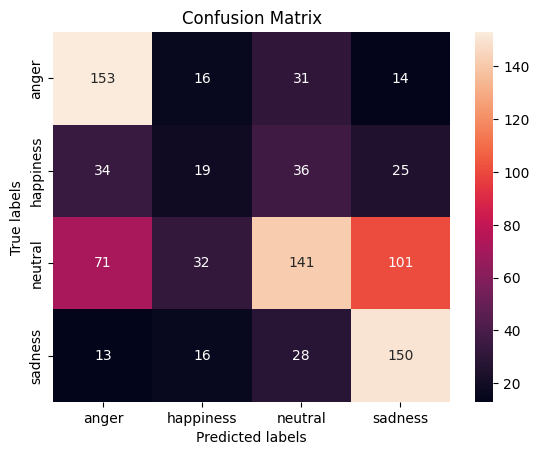


 Classification Report 
               precision    recall  f1-score   support

       anger       0.56      0.71      0.63       214
   happiness       0.23      0.17      0.19       114
     neutral       0.60      0.41      0.49       345
     sadness       0.52      0.72      0.60       207

    accuracy                           0.53       880
   macro avg       0.48      0.50      0.48       880
weighted avg       0.52      0.53      0.51       880
 

Train Epoch: 7 [0/3610 (0%)]	Loss: 1.282722

Train Epoch: 7 [640/3610 (18%)]	Loss: 1.206139

Train Epoch: 7 [1280/3610 (35%)]	Loss: 1.221502

Train Epoch: 7 [1920/3610 (53%)]	Loss: 1.200204

Train Epoch: 7 [2560/3610 (70%)]	Loss: 1.283713

Train Epoch: 7 [3200/3610 (88%)]	Loss: 1.217731


Train set: Average loss: 0.0193


Train Accuracy: 1719/3610 (48%)


Test set: Average loss: 0.0193, Accuracy: 434/880 (49%)



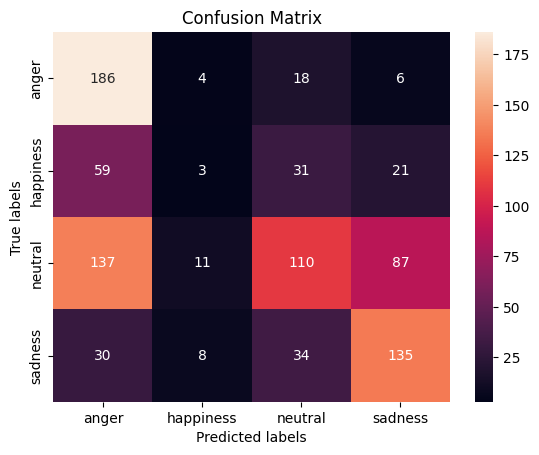


 Classification Report 
               precision    recall  f1-score   support

       anger       0.45      0.87      0.59       214
   happiness       0.12      0.03      0.04       114
     neutral       0.57      0.32      0.41       345
     sadness       0.54      0.65      0.59       207

    accuracy                           0.49       880
   macro avg       0.42      0.47      0.41       880
weighted avg       0.48      0.49      0.45       880
 

Train Epoch: 8 [0/3610 (0%)]	Loss: 1.259940

Train Epoch: 8 [640/3610 (18%)]	Loss: 1.236963

Train Epoch: 8 [1280/3610 (35%)]	Loss: 1.216945

Train Epoch: 8 [1920/3610 (53%)]	Loss: 1.146890

Train Epoch: 8 [2560/3610 (70%)]	Loss: 1.147215

Train Epoch: 8 [3200/3610 (88%)]	Loss: 1.267984


Train set: Average loss: 0.0190


Train Accuracy: 1736/3610 (48%)


Test set: Average loss: 0.0189, Accuracy: 463/880 (53%)



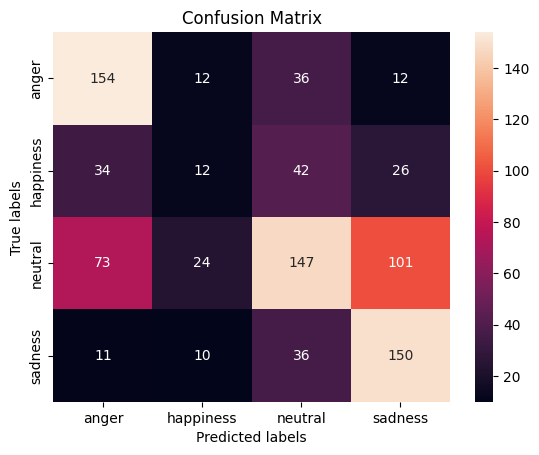


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.72      0.63       214
   happiness       0.21      0.11      0.14       114
     neutral       0.56      0.43      0.49       345
     sadness       0.52      0.72      0.60       207

    accuracy                           0.53       880
   macro avg       0.46      0.49      0.47       880
weighted avg       0.51      0.53      0.50       880
 

Train Epoch: 9 [0/3610 (0%)]	Loss: 1.176881

Train Epoch: 9 [640/3610 (18%)]	Loss: 1.184636

Train Epoch: 9 [1280/3610 (35%)]	Loss: 1.215213

Train Epoch: 9 [1920/3610 (53%)]	Loss: 1.141899

Train Epoch: 9 [2560/3610 (70%)]	Loss: 1.192453

Train Epoch: 9 [3200/3610 (88%)]	Loss: 1.175502


Train set: Average loss: 0.0188


Train Accuracy: 1766/3610 (49%)


Test set: Average loss: 0.0190, Accuracy: 436/880 (50%)



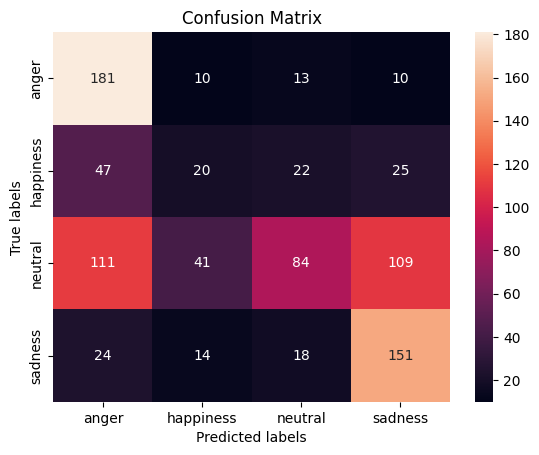


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.85      0.63       214
   happiness       0.24      0.18      0.20       114
     neutral       0.61      0.24      0.35       345
     sadness       0.51      0.73      0.60       207

    accuracy                           0.50       880
   macro avg       0.46      0.50      0.44       880
weighted avg       0.51      0.50      0.46       880
 

Train Epoch: 10 [0/3610 (0%)]	Loss: 1.259929

Train Epoch: 10 [640/3610 (18%)]	Loss: 1.171837

Train Epoch: 10 [1280/3610 (35%)]	Loss: 1.236377

Train Epoch: 10 [1920/3610 (53%)]	Loss: 1.149125

Train Epoch: 10 [2560/3610 (70%)]	Loss: 1.210316

Train Epoch: 10 [3200/3610 (88%)]	Loss: 1.304397


Train set: Average loss: 0.0186


Train Accuracy: 1813/3610 (50%)


Test set: Average loss: 0.0188, Accuracy: 449/880 (51%)



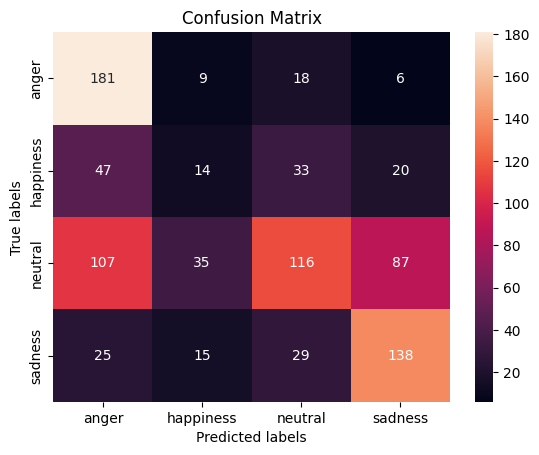


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.85      0.63       214
   happiness       0.19      0.12      0.15       114
     neutral       0.59      0.34      0.43       345
     sadness       0.55      0.67      0.60       207

    accuracy                           0.51       880
   macro avg       0.46      0.49      0.45       880
weighted avg       0.51      0.51      0.48       880
 

Train Epoch: 11 [0/3610 (0%)]	Loss: 1.076591

Train Epoch: 11 [640/3610 (18%)]	Loss: 1.168509

Train Epoch: 11 [1280/3610 (35%)]	Loss: 1.169762

Train Epoch: 11 [1920/3610 (53%)]	Loss: 1.186864

Train Epoch: 11 [2560/3610 (70%)]	Loss: 1.159027

Train Epoch: 11 [3200/3610 (88%)]	Loss: 1.176251


Train set: Average loss: 0.0184


Train Accuracy: 1845/3610 (51%)


Test set: Average loss: 0.0188, Accuracy: 431/880 (49%)



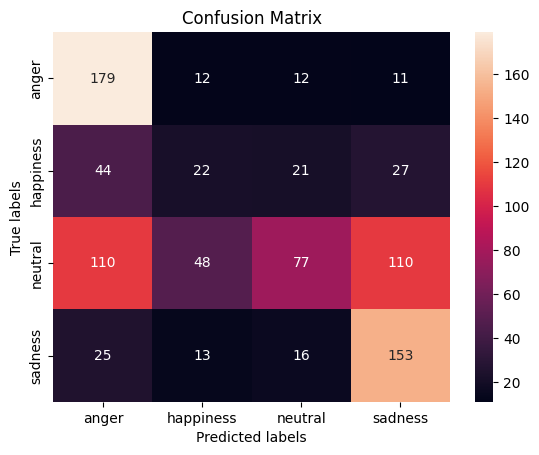


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.84      0.63       214
   happiness       0.23      0.19      0.21       114
     neutral       0.61      0.22      0.33       345
     sadness       0.51      0.74      0.60       207

    accuracy                           0.49       880
   macro avg       0.46      0.50      0.44       880
weighted avg       0.51      0.49      0.45       880
 

Train Epoch: 12 [0/3610 (0%)]	Loss: 1.157295

Train Epoch: 12 [640/3610 (18%)]	Loss: 1.192083

Train Epoch: 12 [1280/3610 (35%)]	Loss: 1.143580

Train Epoch: 12 [1920/3610 (53%)]	Loss: 1.239764

Train Epoch: 12 [2560/3610 (70%)]	Loss: 1.213915

Train Epoch: 12 [3200/3610 (88%)]	Loss: 1.131340


Train set: Average loss: 0.0183


Train Accuracy: 1852/3610 (51%)


Test set: Average loss: 0.0185, Accuracy: 452/880 (51%)



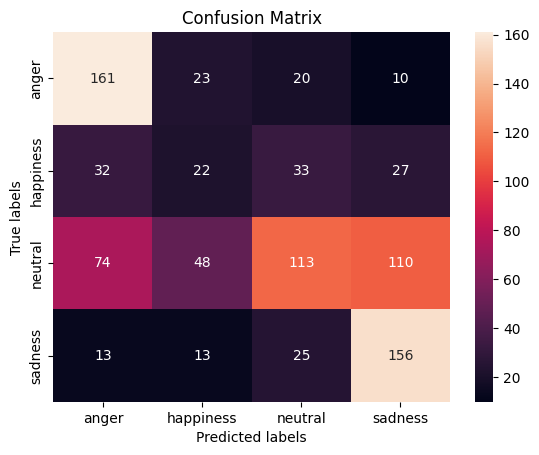


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.75      0.65       214
   happiness       0.21      0.19      0.20       114
     neutral       0.59      0.33      0.42       345
     sadness       0.51      0.75      0.61       207

    accuracy                           0.51       880
   macro avg       0.47      0.51      0.47       880
weighted avg       0.52      0.51      0.49       880
 

Train Epoch: 13 [0/3610 (0%)]	Loss: 1.152977

Train Epoch: 13 [640/3610 (18%)]	Loss: 1.150869

Train Epoch: 13 [1280/3610 (35%)]	Loss: 1.178004

Train Epoch: 13 [1920/3610 (53%)]	Loss: 1.115731

Train Epoch: 13 [2560/3610 (70%)]	Loss: 1.167646

Train Epoch: 13 [3200/3610 (88%)]	Loss: 1.086109


Train set: Average loss: 0.0182


Train Accuracy: 1825/3610 (51%)


Test set: Average loss: 0.0186, Accuracy: 432/880 (49%)



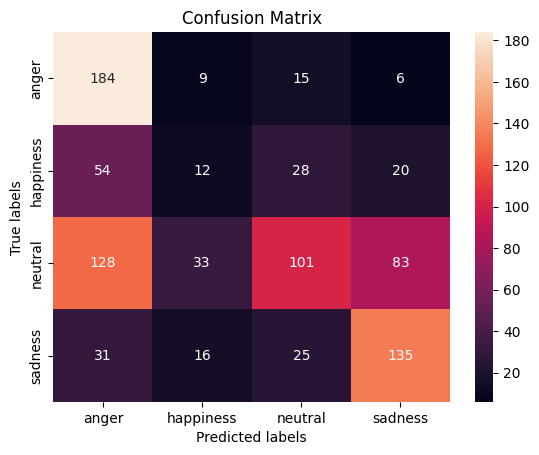


 Classification Report 
               precision    recall  f1-score   support

       anger       0.46      0.86      0.60       214
   happiness       0.17      0.11      0.13       114
     neutral       0.60      0.29      0.39       345
     sadness       0.55      0.65      0.60       207

    accuracy                           0.49       880
   macro avg       0.45      0.48      0.43       880
weighted avg       0.50      0.49      0.46       880
 

Train Epoch: 14 [0/3610 (0%)]	Loss: 1.199682

Train Epoch: 14 [640/3610 (18%)]	Loss: 1.099956

Train Epoch: 14 [1280/3610 (35%)]	Loss: 1.104441

Train Epoch: 14 [1920/3610 (53%)]	Loss: 1.096527

Train Epoch: 14 [2560/3610 (70%)]	Loss: 1.124756

Train Epoch: 14 [3200/3610 (88%)]	Loss: 1.146690


Train set: Average loss: 0.0180


Train Accuracy: 1878/3610 (52%)


Test set: Average loss: 0.0184, Accuracy: 452/880 (51%)



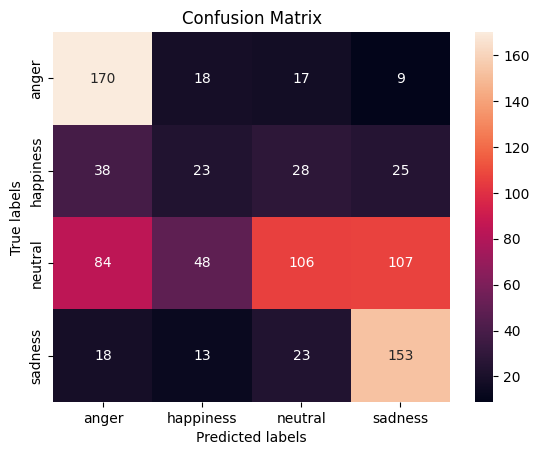


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.79      0.65       214
   happiness       0.23      0.20      0.21       114
     neutral       0.61      0.31      0.41       345
     sadness       0.52      0.74      0.61       207

    accuracy                           0.51       880
   macro avg       0.48      0.51      0.47       880
weighted avg       0.52      0.51      0.49       880
 

Train Epoch: 15 [0/3610 (0%)]	Loss: 1.068763

Train Epoch: 15 [640/3610 (18%)]	Loss: 1.128321

Train Epoch: 15 [1280/3610 (35%)]	Loss: 1.086793

Train Epoch: 15 [1920/3610 (53%)]	Loss: 1.154741

Train Epoch: 15 [2560/3610 (70%)]	Loss: 1.122846

Train Epoch: 15 [3200/3610 (88%)]	Loss: 1.105714


Train set: Average loss: 0.0179


Train Accuracy: 1865/3610 (52%)


Test set: Average loss: 0.0181, Accuracy: 477/880 (54%)



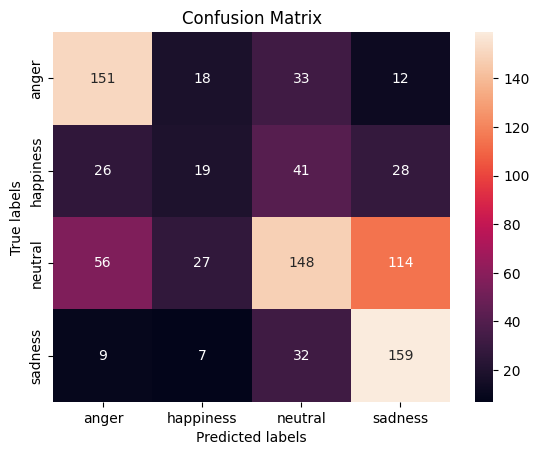


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.71      0.66       214
   happiness       0.27      0.17      0.21       114
     neutral       0.58      0.43      0.49       345
     sadness       0.51      0.77      0.61       207

    accuracy                           0.54       880
   macro avg       0.50      0.52      0.49       880
weighted avg       0.53      0.54      0.53       880
 

Train Epoch: 16 [0/3610 (0%)]	Loss: 1.055179

Train Epoch: 16 [640/3610 (18%)]	Loss: 1.151372

Train Epoch: 16 [1280/3610 (35%)]	Loss: 1.071165

Train Epoch: 16 [1920/3610 (53%)]	Loss: 1.163212

Train Epoch: 16 [2560/3610 (70%)]	Loss: 1.105926

Train Epoch: 16 [3200/3610 (88%)]	Loss: 1.134294


Train set: Average loss: 0.0178


Train Accuracy: 1948/3610 (54%)


Test set: Average loss: 0.0185, Accuracy: 418/880 (48%)



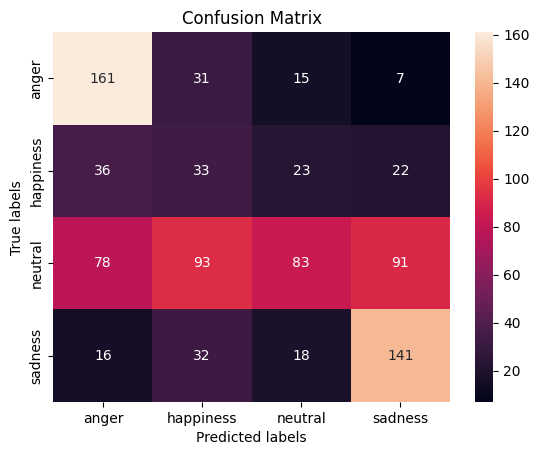


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.75      0.64       214
   happiness       0.17      0.29      0.22       114
     neutral       0.60      0.24      0.34       345
     sadness       0.54      0.68      0.60       207

    accuracy                           0.48       880
   macro avg       0.47      0.49      0.45       880
weighted avg       0.52      0.47      0.46       880
 

Train Epoch: 17 [0/3610 (0%)]	Loss: 1.090861

Train Epoch: 17 [640/3610 (18%)]	Loss: 1.186980

Train Epoch: 17 [1280/3610 (35%)]	Loss: 1.087065

Train Epoch: 17 [1920/3610 (53%)]	Loss: 1.119779

Train Epoch: 17 [2560/3610 (70%)]	Loss: 1.289225

Train Epoch: 17 [3200/3610 (88%)]	Loss: 1.071805


Train set: Average loss: 0.0178


Train Accuracy: 1904/3610 (53%)


Test set: Average loss: 0.0184, Accuracy: 425/880 (48%)



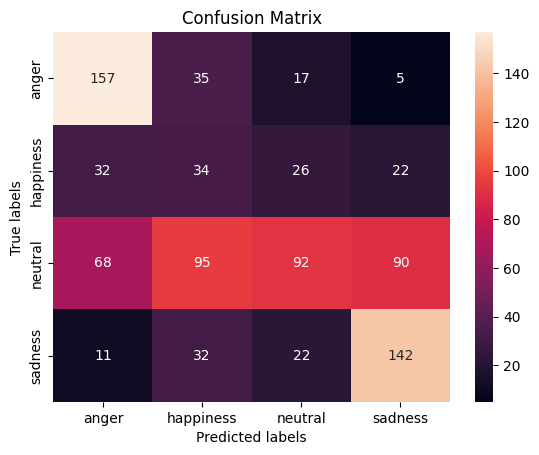


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.73      0.65       214
   happiness       0.17      0.30      0.22       114
     neutral       0.59      0.27      0.37       345
     sadness       0.55      0.69      0.61       207

    accuracy                           0.48       880
   macro avg       0.47      0.50      0.46       880
weighted avg       0.52      0.48      0.47       880
 

Train Epoch: 18 [0/3610 (0%)]	Loss: 1.068961

Train Epoch: 18 [640/3610 (18%)]	Loss: 1.161826

Train Epoch: 18 [1280/3610 (35%)]	Loss: 1.011082

Train Epoch: 18 [1920/3610 (53%)]	Loss: 1.107717

Train Epoch: 18 [2560/3610 (70%)]	Loss: 1.071971

Train Epoch: 18 [3200/3610 (88%)]	Loss: 1.092178


Train set: Average loss: 0.0176


Train Accuracy: 1919/3610 (53%)


Test set: Average loss: 0.0178, Accuracy: 480/880 (55%)



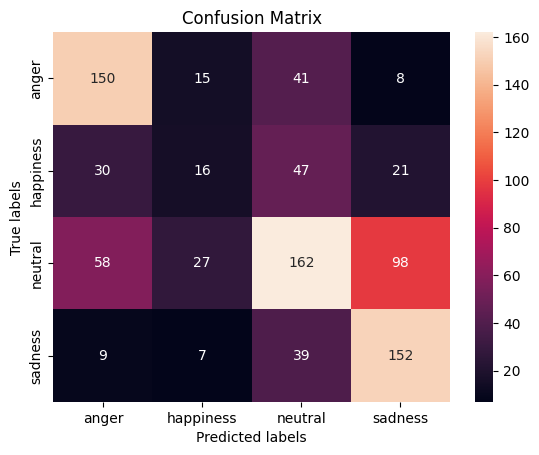


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.70      0.65       214
   happiness       0.25      0.14      0.18       114
     neutral       0.56      0.47      0.51       345
     sadness       0.54      0.73      0.63       207

    accuracy                           0.55       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.53      0.55      0.53       880
 

Train Epoch: 19 [0/3610 (0%)]	Loss: 1.196304

Train Epoch: 19 [640/3610 (18%)]	Loss: 1.021463

Train Epoch: 19 [1280/3610 (35%)]	Loss: 1.017886

Train Epoch: 19 [1920/3610 (53%)]	Loss: 1.086691

Train Epoch: 19 [2560/3610 (70%)]	Loss: 1.195565

Train Epoch: 19 [3200/3610 (88%)]	Loss: 1.287974


Train set: Average loss: 0.0175


Train Accuracy: 1920/3610 (53%)


Test set: Average loss: 0.0181, Accuracy: 458/880 (52%)



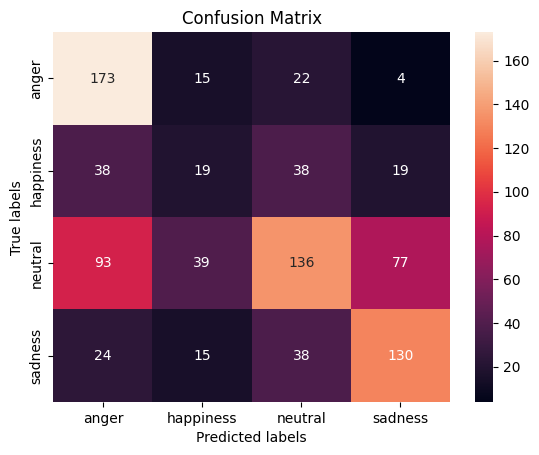


 Classification Report 
               precision    recall  f1-score   support

       anger       0.53      0.81      0.64       214
   happiness       0.22      0.17      0.19       114
     neutral       0.58      0.39      0.47       345
     sadness       0.57      0.63      0.59       207

    accuracy                           0.52       880
   macro avg       0.47      0.50      0.47       880
weighted avg       0.52      0.52      0.50       880
 

Train Epoch: 20 [0/3610 (0%)]	Loss: 1.075507

Train Epoch: 20 [640/3610 (18%)]	Loss: 1.146766

Train Epoch: 20 [1280/3610 (35%)]	Loss: 1.109734

Train Epoch: 20 [1920/3610 (53%)]	Loss: 1.220120

Train Epoch: 20 [2560/3610 (70%)]	Loss: 1.121736

Train Epoch: 20 [3200/3610 (88%)]	Loss: 1.049100


Train set: Average loss: 0.0175


Train Accuracy: 1936/3610 (54%)


Test set: Average loss: 0.0184, Accuracy: 417/880 (47%)



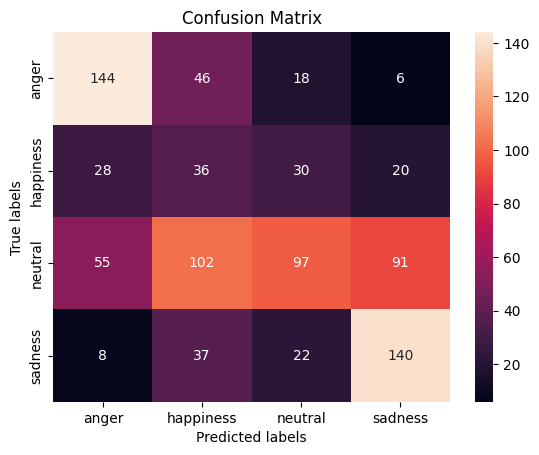


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.67      0.64       214
   happiness       0.16      0.32      0.21       114
     neutral       0.58      0.28      0.38       345
     sadness       0.54      0.68      0.60       207

    accuracy                           0.47       880
   macro avg       0.48      0.49      0.46       880
weighted avg       0.53      0.47      0.47       880
 

Train Epoch: 21 [0/3610 (0%)]	Loss: 1.146063

Train Epoch: 21 [640/3610 (18%)]	Loss: 1.048265

Train Epoch: 21 [1280/3610 (35%)]	Loss: 1.098372

Train Epoch: 21 [1920/3610 (53%)]	Loss: 0.981113

Train Epoch: 21 [2560/3610 (70%)]	Loss: 1.106564

Train Epoch: 21 [3200/3610 (88%)]	Loss: 1.123196


Train set: Average loss: 0.0175


Train Accuracy: 1931/3610 (53%)


Test set: Average loss: 0.0179, Accuracy: 477/880 (54%)



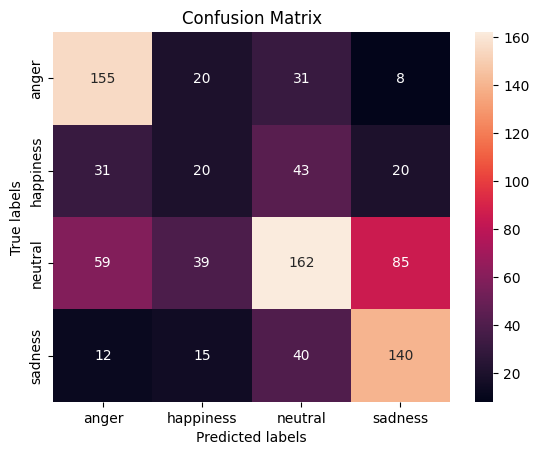


 Classification Report 
               precision    recall  f1-score   support

       anger       0.60      0.72      0.66       214
   happiness       0.21      0.18      0.19       114
     neutral       0.59      0.47      0.52       345
     sadness       0.55      0.68      0.61       207

    accuracy                           0.54       880
   macro avg       0.49      0.51      0.50       880
weighted avg       0.53      0.54      0.53       880
 

Train Epoch: 22 [0/3610 (0%)]	Loss: 1.207328

Train Epoch: 22 [640/3610 (18%)]	Loss: 1.070687

Train Epoch: 22 [1280/3610 (35%)]	Loss: 0.979936

Train Epoch: 22 [1920/3610 (53%)]	Loss: 1.119701

Train Epoch: 22 [2560/3610 (70%)]	Loss: 1.116929

Train Epoch: 22 [3200/3610 (88%)]	Loss: 1.141035


Train set: Average loss: 0.0175


Train Accuracy: 1924/3610 (53%)


Test set: Average loss: 0.0180, Accuracy: 455/880 (52%)



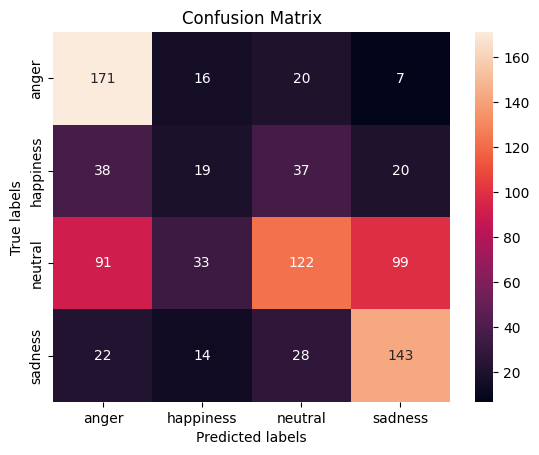


 Classification Report 
               precision    recall  f1-score   support

       anger       0.53      0.80      0.64       214
   happiness       0.23      0.17      0.19       114
     neutral       0.59      0.35      0.44       345
     sadness       0.53      0.69      0.60       207

    accuracy                           0.52       880
   macro avg       0.47      0.50      0.47       880
weighted avg       0.52      0.52      0.49       880
 

Train Epoch: 23 [0/3610 (0%)]	Loss: 0.993331

Train Epoch: 23 [640/3610 (18%)]	Loss: 1.058741

Train Epoch: 23 [1280/3610 (35%)]	Loss: 1.073537

Train Epoch: 23 [1920/3610 (53%)]	Loss: 1.074032

Train Epoch: 23 [2560/3610 (70%)]	Loss: 1.097764

Train Epoch: 23 [3200/3610 (88%)]	Loss: 1.130973


Train set: Average loss: 0.0174


Train Accuracy: 1932/3610 (54%)


Test set: Average loss: 0.0178, Accuracy: 466/880 (53%)



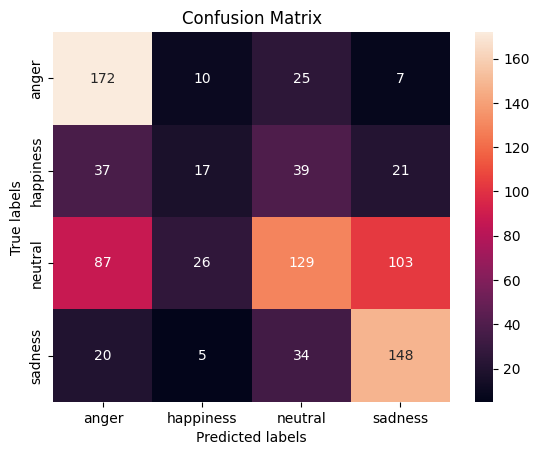


 Classification Report 
               precision    recall  f1-score   support

       anger       0.54      0.80      0.65       214
   happiness       0.29      0.15      0.20       114
     neutral       0.57      0.37      0.45       345
     sadness       0.53      0.71      0.61       207

    accuracy                           0.53       880
   macro avg       0.48      0.51      0.48       880
weighted avg       0.52      0.53      0.50       880
 

Train Epoch: 24 [0/3610 (0%)]	Loss: 1.130474

Train Epoch: 24 [640/3610 (18%)]	Loss: 1.146598

Train Epoch: 24 [1280/3610 (35%)]	Loss: 1.182202

Train Epoch: 24 [1920/3610 (53%)]	Loss: 1.081505

Train Epoch: 24 [2560/3610 (70%)]	Loss: 0.970467

Train Epoch: 24 [3200/3610 (88%)]	Loss: 1.134955


Train set: Average loss: 0.0173


Train Accuracy: 1962/3610 (54%)


Test set: Average loss: 0.0176, Accuracy: 480/880 (55%)



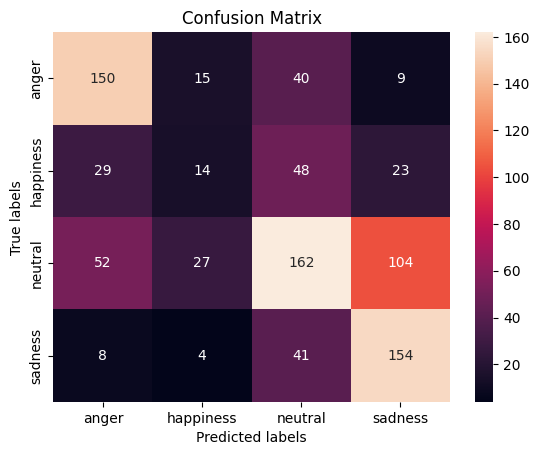


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.70      0.66       214
   happiness       0.23      0.12      0.16       114
     neutral       0.56      0.47      0.51       345
     sadness       0.53      0.74      0.62       207

    accuracy                           0.55       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.53      0.55      0.53       880
 

Train Epoch: 25 [0/3610 (0%)]	Loss: 1.125753

Train Epoch: 25 [640/3610 (18%)]	Loss: 1.147552

Train Epoch: 25 [1280/3610 (35%)]	Loss: 1.084403

Train Epoch: 25 [1920/3610 (53%)]	Loss: 0.893004

Train Epoch: 25 [2560/3610 (70%)]	Loss: 1.119751

Train Epoch: 25 [3200/3610 (88%)]	Loss: 1.059068


Train set: Average loss: 0.0173


Train Accuracy: 1957/3610 (54%)


Test set: Average loss: 0.0178, Accuracy: 477/880 (54%)



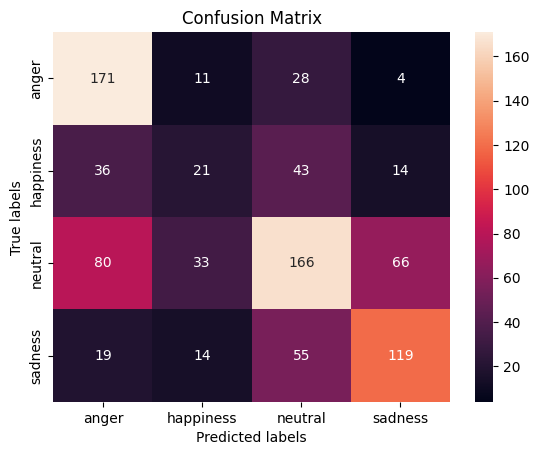


 Classification Report 
               precision    recall  f1-score   support

       anger       0.56      0.80      0.66       214
   happiness       0.27      0.18      0.22       114
     neutral       0.57      0.48      0.52       345
     sadness       0.59      0.57      0.58       207

    accuracy                           0.54       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.53      0.54      0.53       880
 

Train Epoch: 26 [0/3610 (0%)]	Loss: 1.058042

Train Epoch: 26 [640/3610 (18%)]	Loss: 1.039035

Train Epoch: 26 [1280/3610 (35%)]	Loss: 1.089525

Train Epoch: 26 [1920/3610 (53%)]	Loss: 0.944803

Train Epoch: 26 [2560/3610 (70%)]	Loss: 1.106438

Train Epoch: 26 [3200/3610 (88%)]	Loss: 1.229600


Train set: Average loss: 0.0172


Train Accuracy: 1981/3610 (55%)


Test set: Average loss: 0.0177, Accuracy: 472/880 (54%)



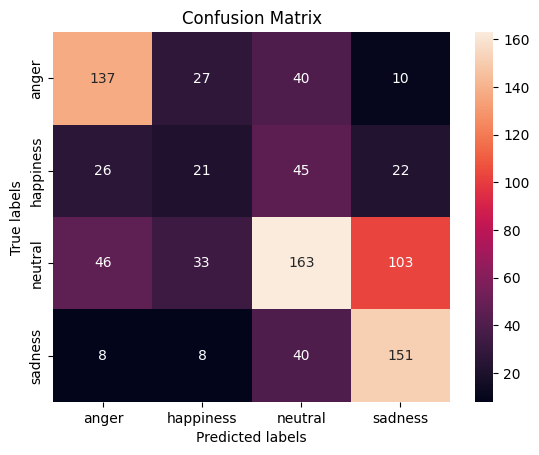


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.64      0.64       214
   happiness       0.24      0.18      0.21       114
     neutral       0.57      0.47      0.52       345
     sadness       0.53      0.73      0.61       207

    accuracy                           0.54       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.53      0.54      0.53       880
 

Train Epoch: 27 [0/3610 (0%)]	Loss: 1.036281

Train Epoch: 27 [640/3610 (18%)]	Loss: 1.105761

Train Epoch: 27 [1280/3610 (35%)]	Loss: 0.996270

Train Epoch: 27 [1920/3610 (53%)]	Loss: 0.950843

Train Epoch: 27 [2560/3610 (70%)]	Loss: 1.089816

Train Epoch: 27 [3200/3610 (88%)]	Loss: 1.139876


Train set: Average loss: 0.0172


Train Accuracy: 1991/3610 (55%)


Test set: Average loss: 0.0178, Accuracy: 463/880 (53%)



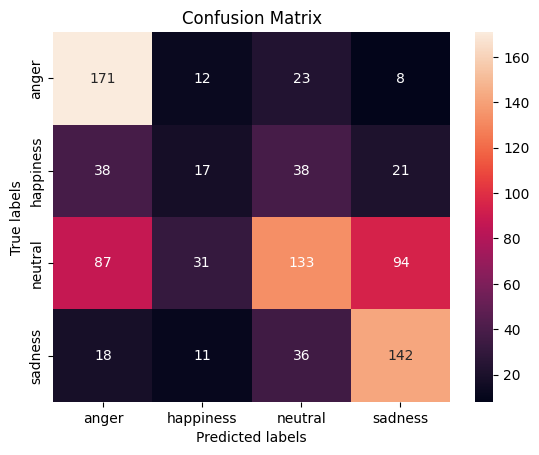


 Classification Report 
               precision    recall  f1-score   support

       anger       0.54      0.80      0.65       214
   happiness       0.24      0.15      0.18       114
     neutral       0.58      0.39      0.46       345
     sadness       0.54      0.69      0.60       207

    accuracy                           0.53       880
   macro avg       0.47      0.50      0.47       880
weighted avg       0.52      0.53      0.50       880
 

Train Epoch: 28 [0/3610 (0%)]	Loss: 1.202279

Train Epoch: 28 [640/3610 (18%)]	Loss: 1.071321

Train Epoch: 28 [1280/3610 (35%)]	Loss: 1.100226

Train Epoch: 28 [1920/3610 (53%)]	Loss: 1.105015

Train Epoch: 28 [2560/3610 (70%)]	Loss: 1.080793

Train Epoch: 28 [3200/3610 (88%)]	Loss: 1.100337


Train set: Average loss: 0.0172


Train Accuracy: 1968/3610 (55%)


Test set: Average loss: 0.0177, Accuracy: 475/880 (54%)



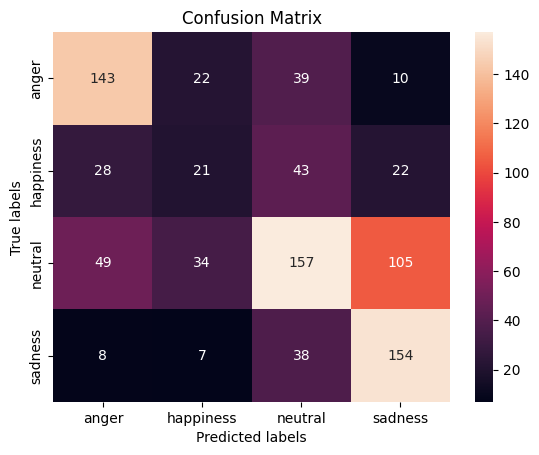


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.67      0.65       214
   happiness       0.25      0.18      0.21       114
     neutral       0.57      0.46      0.50       345
     sadness       0.53      0.74      0.62       207

    accuracy                           0.54       880
   macro avg       0.49      0.51      0.50       880
weighted avg       0.53      0.54      0.53       880
 

Train Epoch: 29 [0/3610 (0%)]	Loss: 0.982471

Train Epoch: 29 [640/3610 (18%)]	Loss: 1.041779

Train Epoch: 29 [1280/3610 (35%)]	Loss: 1.047548

Train Epoch: 29 [1920/3610 (53%)]	Loss: 1.021306

Train Epoch: 29 [2560/3610 (70%)]	Loss: 1.157670

Train Epoch: 29 [3200/3610 (88%)]	Loss: 1.017533


Train set: Average loss: 0.0172


Train Accuracy: 1941/3610 (54%)


Test set: Average loss: 0.0184, Accuracy: 412/880 (47%)



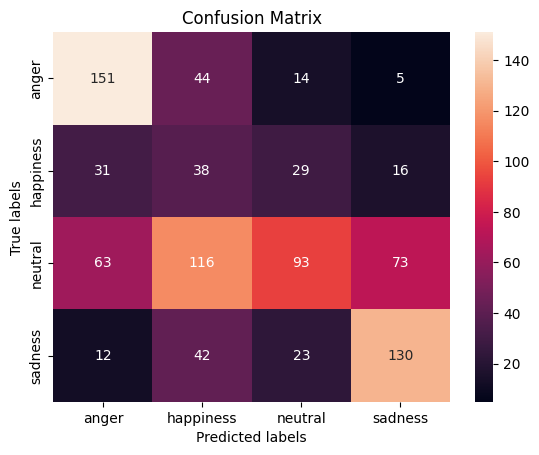


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.71      0.64       214
   happiness       0.16      0.33      0.21       114
     neutral       0.58      0.27      0.37       345
     sadness       0.58      0.63      0.60       207

    accuracy                           0.47       880
   macro avg       0.48      0.48      0.46       880
weighted avg       0.53      0.47      0.47       880
 

Train Epoch: 30 [0/3610 (0%)]	Loss: 1.017146

Train Epoch: 30 [640/3610 (18%)]	Loss: 1.107766

Train Epoch: 30 [1280/3610 (35%)]	Loss: 1.230523

Train Epoch: 30 [1920/3610 (53%)]	Loss: 1.095391

Train Epoch: 30 [2560/3610 (70%)]	Loss: 1.035765

Train Epoch: 30 [3200/3610 (88%)]	Loss: 1.098825


Train set: Average loss: 0.0169


Train Accuracy: 1983/3610 (55%)


Test set: Average loss: 0.0179, Accuracy: 460/880 (52%)



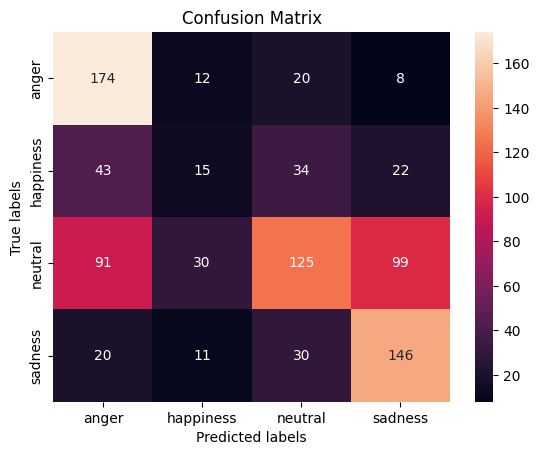


 Classification Report 
               precision    recall  f1-score   support

       anger       0.53      0.81      0.64       214
   happiness       0.22      0.13      0.16       114
     neutral       0.60      0.36      0.45       345
     sadness       0.53      0.71      0.61       207

    accuracy                           0.52       880
   macro avg       0.47      0.50      0.47       880
weighted avg       0.52      0.52      0.50       880
 

Train Epoch: 31 [0/3610 (0%)]	Loss: 1.222658

Train Epoch: 31 [640/3610 (18%)]	Loss: 1.001931

Train Epoch: 31 [1280/3610 (35%)]	Loss: 1.072273

Train Epoch: 31 [1920/3610 (53%)]	Loss: 1.014678

Train Epoch: 31 [2560/3610 (70%)]	Loss: 1.188421

Train Epoch: 31 [3200/3610 (88%)]	Loss: 0.951032


Train set: Average loss: 0.0170


Train Accuracy: 1960/3610 (54%)


Test set: Average loss: 0.0175, Accuracy: 488/880 (55%)



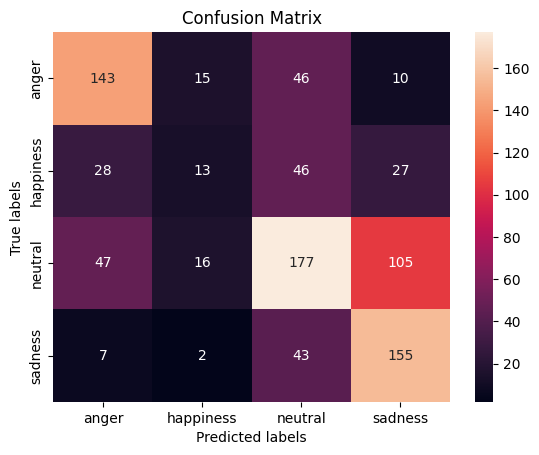


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.67      0.65       214
   happiness       0.28      0.11      0.16       114
     neutral       0.57      0.51      0.54       345
     sadness       0.52      0.75      0.62       207

    accuracy                           0.55       880
   macro avg       0.50      0.51      0.49       880
weighted avg       0.54      0.55      0.54       880
 

Train Epoch: 32 [0/3610 (0%)]	Loss: 1.069476

Train Epoch: 32 [640/3610 (18%)]	Loss: 1.124513

Train Epoch: 32 [1280/3610 (35%)]	Loss: 1.038038

Train Epoch: 32 [1920/3610 (53%)]	Loss: 1.014108

Train Epoch: 32 [2560/3610 (70%)]	Loss: 1.186077

Train Epoch: 32 [3200/3610 (88%)]	Loss: 0.979115


Train set: Average loss: 0.0169


Train Accuracy: 1998/3610 (55%)


Test set: Average loss: 0.0178, Accuracy: 459/880 (52%)



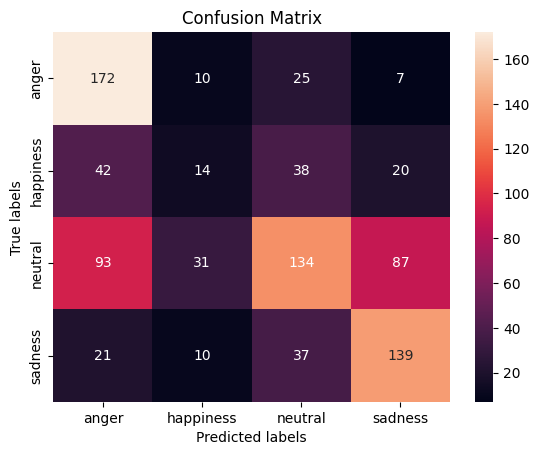


 Classification Report 
               precision    recall  f1-score   support

       anger       0.52      0.80      0.63       214
   happiness       0.22      0.12      0.16       114
     neutral       0.57      0.39      0.46       345
     sadness       0.55      0.67      0.60       207

    accuracy                           0.52       880
   macro avg       0.47      0.50      0.46       880
weighted avg       0.51      0.52      0.50       880
 

Train Epoch: 33 [0/3610 (0%)]	Loss: 1.018798

Train Epoch: 33 [640/3610 (18%)]	Loss: 1.090467

Train Epoch: 33 [1280/3610 (35%)]	Loss: 1.003005

Train Epoch: 33 [1920/3610 (53%)]	Loss: 1.087781

Train Epoch: 33 [2560/3610 (70%)]	Loss: 1.140928

Train Epoch: 33 [3200/3610 (88%)]	Loss: 1.078044


Train set: Average loss: 0.0169


Train Accuracy: 1982/3610 (55%)


Test set: Average loss: 0.0179, Accuracy: 460/880 (52%)



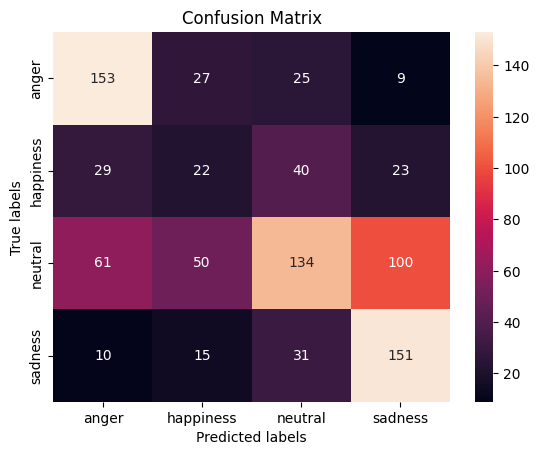


 Classification Report 
               precision    recall  f1-score   support

       anger       0.60      0.71      0.66       214
   happiness       0.19      0.19      0.19       114
     neutral       0.58      0.39      0.47       345
     sadness       0.53      0.73      0.62       207

    accuracy                           0.52       880
   macro avg       0.48      0.51      0.48       880
weighted avg       0.53      0.52      0.51       880
 

Train Epoch: 34 [0/3610 (0%)]	Loss: 1.118884

Train Epoch: 34 [640/3610 (18%)]	Loss: 1.046170

Train Epoch: 34 [1280/3610 (35%)]	Loss: 0.941662

Train Epoch: 34 [1920/3610 (53%)]	Loss: 1.168107

Train Epoch: 34 [2560/3610 (70%)]	Loss: 1.068515

Train Epoch: 34 [3200/3610 (88%)]	Loss: 1.100921


Train set: Average loss: 0.0169


Train Accuracy: 1999/3610 (55%)


Test set: Average loss: 0.0179, Accuracy: 456/880 (52%)



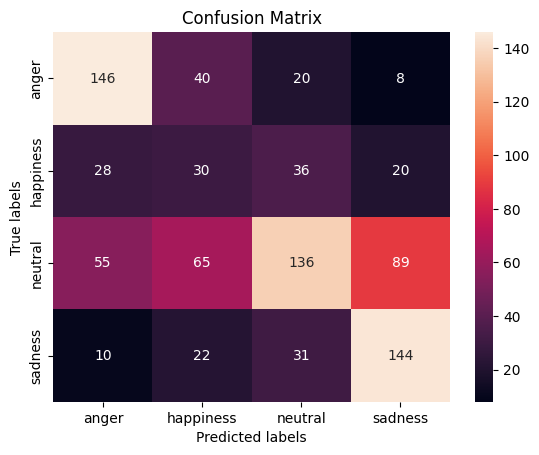


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.68      0.64       214
   happiness       0.19      0.26      0.22       114
     neutral       0.61      0.39      0.48       345
     sadness       0.55      0.70      0.62       207

    accuracy                           0.52       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.54      0.52      0.52       880
 

Train Epoch: 35 [0/3610 (0%)]	Loss: 1.009764

Train Epoch: 35 [640/3610 (18%)]	Loss: 1.031122

Train Epoch: 35 [1280/3610 (35%)]	Loss: 1.110832

Train Epoch: 35 [1920/3610 (53%)]	Loss: 1.030224

Train Epoch: 35 [2560/3610 (70%)]	Loss: 1.041833

Train Epoch: 35 [3200/3610 (88%)]	Loss: 1.016703


Train set: Average loss: 0.0168


Train Accuracy: 1991/3610 (55%)


Test set: Average loss: 0.0178, Accuracy: 463/880 (53%)



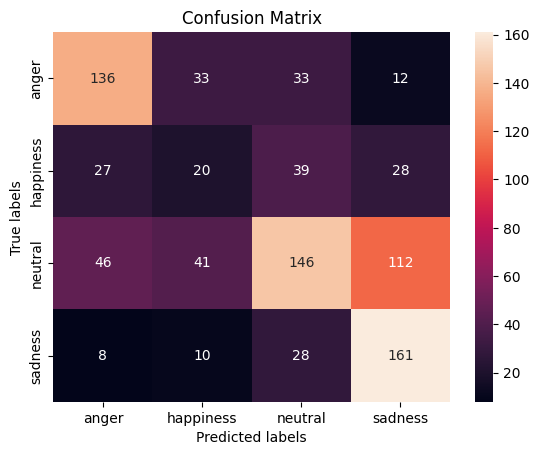


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.64      0.63       214
   happiness       0.19      0.18      0.18       114
     neutral       0.59      0.42      0.49       345
     sadness       0.51      0.78      0.62       207

    accuracy                           0.53       880
   macro avg       0.48      0.50      0.48       880
weighted avg       0.53      0.53      0.52       880
 

Train Epoch: 36 [0/3610 (0%)]	Loss: 1.080228

Train Epoch: 36 [640/3610 (18%)]	Loss: 1.015635

Train Epoch: 36 [1280/3610 (35%)]	Loss: 1.038669

Train Epoch: 36 [1920/3610 (53%)]	Loss: 1.081213

Train Epoch: 36 [2560/3610 (70%)]	Loss: 0.982582

Train Epoch: 36 [3200/3610 (88%)]	Loss: 1.073562


Train set: Average loss: 0.0167


Train Accuracy: 2016/3610 (56%)


Test set: Average loss: 0.0180, Accuracy: 449/880 (51%)



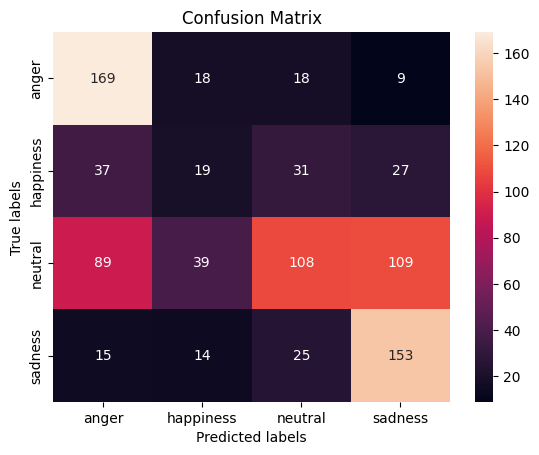


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.79      0.65       214
   happiness       0.21      0.17      0.19       114
     neutral       0.59      0.31      0.41       345
     sadness       0.51      0.74      0.61       207

    accuracy                           0.51       880
   macro avg       0.47      0.50      0.46       880
weighted avg       0.51      0.51      0.48       880
 

Train Epoch: 37 [0/3610 (0%)]	Loss: 1.041104

Train Epoch: 37 [640/3610 (18%)]	Loss: 1.006730

Train Epoch: 37 [1280/3610 (35%)]	Loss: 1.130159

Train Epoch: 37 [1920/3610 (53%)]	Loss: 1.070685

Train Epoch: 37 [2560/3610 (70%)]	Loss: 1.063473

Train Epoch: 37 [3200/3610 (88%)]	Loss: 1.022601


Train set: Average loss: 0.0167


Train Accuracy: 2024/3610 (56%)


Test set: Average loss: 0.0181, Accuracy: 434/880 (49%)



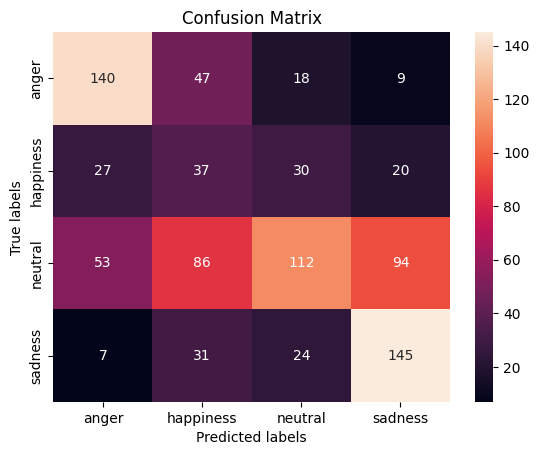


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.65      0.63       214
   happiness       0.18      0.32      0.23       114
     neutral       0.61      0.32      0.42       345
     sadness       0.54      0.70      0.61       207

    accuracy                           0.49       880
   macro avg       0.49      0.50      0.48       880
weighted avg       0.54      0.49      0.49       880
 

Train Epoch: 38 [0/3610 (0%)]	Loss: 1.012439

Train Epoch: 38 [640/3610 (18%)]	Loss: 1.126331

Train Epoch: 38 [1280/3610 (35%)]	Loss: 0.905748

Train Epoch: 38 [1920/3610 (53%)]	Loss: 1.125458

Train Epoch: 38 [2560/3610 (70%)]	Loss: 1.111565

Train Epoch: 38 [3200/3610 (88%)]	Loss: 1.126636


Train set: Average loss: 0.0168


Train Accuracy: 1986/3610 (55%)


Test set: Average loss: 0.0179, Accuracy: 460/880 (52%)



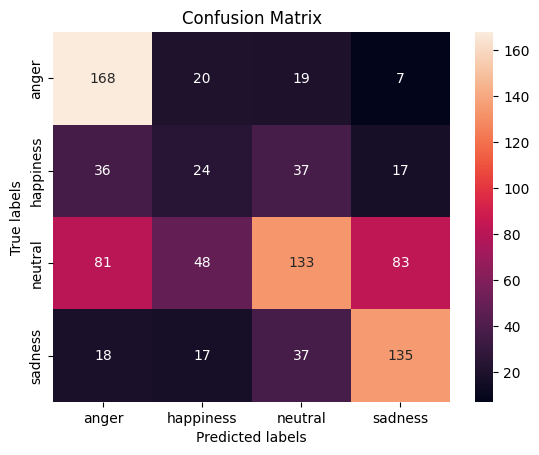


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.79      0.65       214
   happiness       0.22      0.21      0.22       114
     neutral       0.59      0.39      0.47       345
     sadness       0.56      0.65      0.60       207

    accuracy                           0.52       880
   macro avg       0.48      0.51      0.48       880
weighted avg       0.53      0.52      0.51       880
 

Train Epoch: 39 [0/3610 (0%)]	Loss: 1.170411

Train Epoch: 39 [640/3610 (18%)]	Loss: 1.113496

Train Epoch: 39 [1280/3610 (35%)]	Loss: 0.996579

Train Epoch: 39 [1920/3610 (53%)]	Loss: 1.109040

Train Epoch: 39 [2560/3610 (70%)]	Loss: 0.988810

Train Epoch: 39 [3200/3610 (88%)]	Loss: 1.110189


Train set: Average loss: 0.0167


Train Accuracy: 2007/3610 (56%)


Test set: Average loss: 0.0181, Accuracy: 436/880 (50%)



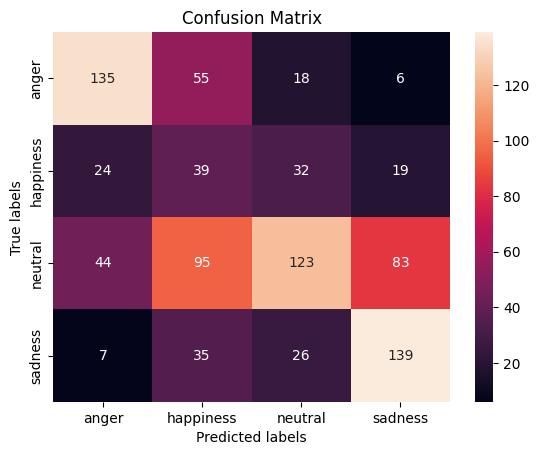


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.63      0.64       214
   happiness       0.17      0.34      0.23       114
     neutral       0.62      0.36      0.45       345
     sadness       0.56      0.67      0.61       207

    accuracy                           0.50       880
   macro avg       0.50      0.50      0.48       880
weighted avg       0.55      0.50      0.51       880
 

Train Epoch: 40 [0/3610 (0%)]	Loss: 0.927089

Train Epoch: 40 [640/3610 (18%)]	Loss: 0.949008

Train Epoch: 40 [1280/3610 (35%)]	Loss: 1.048225

Train Epoch: 40 [1920/3610 (53%)]	Loss: 1.052314

Train Epoch: 40 [2560/3610 (70%)]	Loss: 1.208101

Train Epoch: 40 [3200/3610 (88%)]	Loss: 0.980982


Train set: Average loss: 0.0167


Train Accuracy: 2015/3610 (56%)


Test set: Average loss: 0.0178, Accuracy: 460/880 (52%)



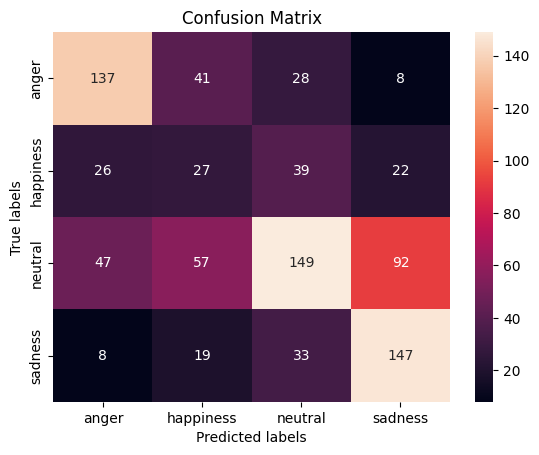


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.64      0.63       214
   happiness       0.19      0.24      0.21       114
     neutral       0.60      0.43      0.50       345
     sadness       0.55      0.71      0.62       207

    accuracy                           0.52       880
   macro avg       0.49      0.50      0.49       880
weighted avg       0.54      0.52      0.52       880
 

Train Epoch: 41 [0/3610 (0%)]	Loss: 0.947425

Train Epoch: 41 [640/3610 (18%)]	Loss: 0.969006

Train Epoch: 41 [1280/3610 (35%)]	Loss: 1.128459

Train Epoch: 41 [1920/3610 (53%)]	Loss: 1.010148

Train Epoch: 41 [2560/3610 (70%)]	Loss: 1.117049

Train Epoch: 41 [3200/3610 (88%)]	Loss: 1.044620


Train set: Average loss: 0.0168


Train Accuracy: 2003/3610 (55%)


Test set: Average loss: 0.0179, Accuracy: 461/880 (52%)



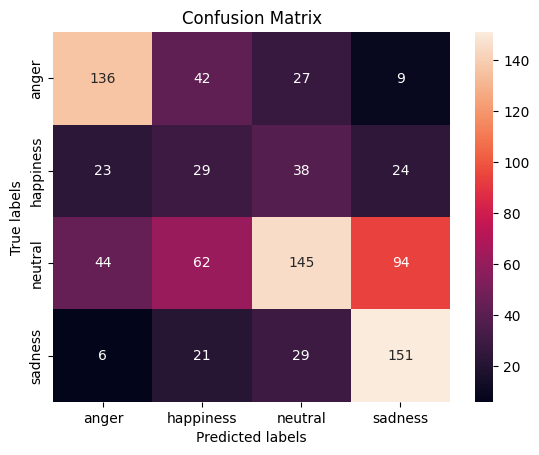


 Classification Report 
               precision    recall  f1-score   support

       anger       0.65      0.64      0.64       214
   happiness       0.19      0.25      0.22       114
     neutral       0.61      0.42      0.50       345
     sadness       0.54      0.73      0.62       207

    accuracy                           0.52       880
   macro avg       0.50      0.51      0.49       880
weighted avg       0.55      0.52      0.53       880
 

Train Epoch: 42 [0/3610 (0%)]	Loss: 1.131590

Train Epoch: 42 [640/3610 (18%)]	Loss: 0.981857

Train Epoch: 42 [1280/3610 (35%)]	Loss: 1.151142

Train Epoch: 42 [1920/3610 (53%)]	Loss: 0.962370

Train Epoch: 42 [2560/3610 (70%)]	Loss: 0.911809

Train Epoch: 42 [3200/3610 (88%)]	Loss: 1.118404


Train set: Average loss: 0.0167


Train Accuracy: 2025/3610 (56%)


Test set: Average loss: 0.0175, Accuracy: 487/880 (55%)



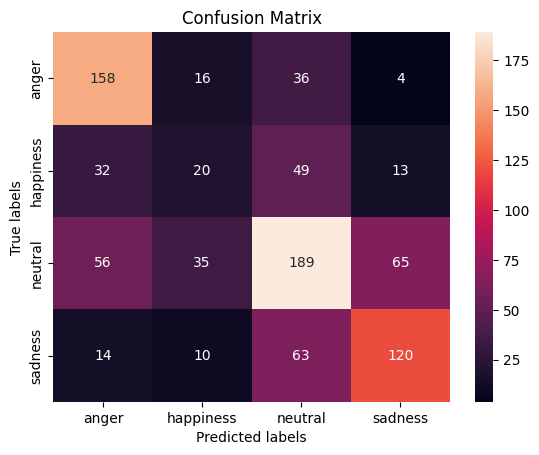


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.74      0.67       214
   happiness       0.25      0.18      0.21       114
     neutral       0.56      0.55      0.55       345
     sadness       0.59      0.58      0.59       207

    accuracy                           0.55       880
   macro avg       0.50      0.51      0.50       880
weighted avg       0.54      0.55      0.54       880
 

Train Epoch: 43 [0/3610 (0%)]	Loss: 1.196629

Train Epoch: 43 [640/3610 (18%)]	Loss: 1.134086

Train Epoch: 43 [1280/3610 (35%)]	Loss: 0.913138

Train Epoch: 43 [1920/3610 (53%)]	Loss: 1.048616

Train Epoch: 43 [2560/3610 (70%)]	Loss: 1.099497

Train Epoch: 43 [3200/3610 (88%)]	Loss: 1.050190


Train set: Average loss: 0.0166


Train Accuracy: 2033/3610 (56%)


Test set: Average loss: 0.0177, Accuracy: 463/880 (53%)



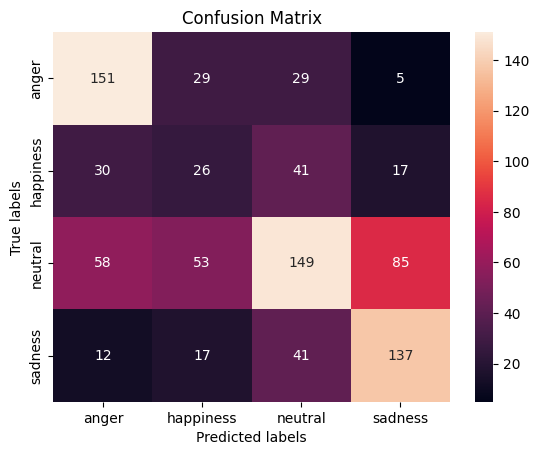


 Classification Report 
               precision    recall  f1-score   support

       anger       0.60      0.71      0.65       214
   happiness       0.21      0.23      0.22       114
     neutral       0.57      0.43      0.49       345
     sadness       0.56      0.66      0.61       207

    accuracy                           0.53       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.53      0.53      0.52       880
 

Train Epoch: 44 [0/3610 (0%)]	Loss: 1.184330

Train Epoch: 44 [640/3610 (18%)]	Loss: 0.998350

Train Epoch: 44 [1280/3610 (35%)]	Loss: 1.132020

Train Epoch: 44 [1920/3610 (53%)]	Loss: 0.961833

Train Epoch: 44 [2560/3610 (70%)]	Loss: 0.956525

Train Epoch: 44 [3200/3610 (88%)]	Loss: 1.046357


Train set: Average loss: 0.0164


Train Accuracy: 2066/3610 (57%)


Test set: Average loss: 0.0177, Accuracy: 474/880 (54%)



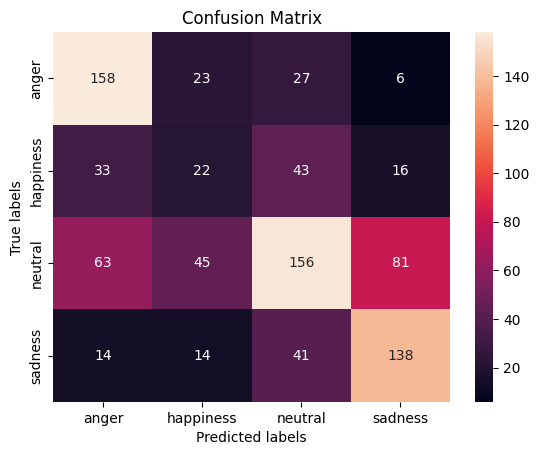


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.74      0.66       214
   happiness       0.21      0.19      0.20       114
     neutral       0.58      0.45      0.51       345
     sadness       0.57      0.67      0.62       207

    accuracy                           0.54       880
   macro avg       0.49      0.51      0.50       880
weighted avg       0.53      0.54      0.53       880
 

Train Epoch: 45 [0/3610 (0%)]	Loss: 1.009381

Train Epoch: 45 [640/3610 (18%)]	Loss: 1.061587

Train Epoch: 45 [1280/3610 (35%)]	Loss: 1.118285

Train Epoch: 45 [1920/3610 (53%)]	Loss: 1.026816

Train Epoch: 45 [2560/3610 (70%)]	Loss: 0.946848

Train Epoch: 45 [3200/3610 (88%)]	Loss: 1.062243


Train set: Average loss: 0.0163


Train Accuracy: 2068/3610 (57%)


Test set: Average loss: 0.0176, Accuracy: 474/880 (54%)



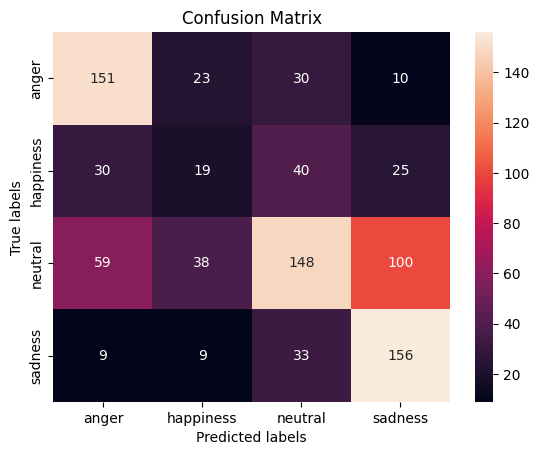


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.71      0.65       214
   happiness       0.21      0.17      0.19       114
     neutral       0.59      0.43      0.50       345
     sadness       0.54      0.75      0.63       207

    accuracy                           0.54       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.53      0.54      0.52       880
 

Train Epoch: 46 [0/3610 (0%)]	Loss: 1.118128

Train Epoch: 46 [640/3610 (18%)]	Loss: 1.072910

Train Epoch: 46 [1280/3610 (35%)]	Loss: 0.946293

Train Epoch: 46 [1920/3610 (53%)]	Loss: 1.084793

Train Epoch: 46 [2560/3610 (70%)]	Loss: 1.068754

Train Epoch: 46 [3200/3610 (88%)]	Loss: 1.126197


Train set: Average loss: 0.0163


Train Accuracy: 2068/3610 (57%)


Test set: Average loss: 0.0178, Accuracy: 465/880 (53%)



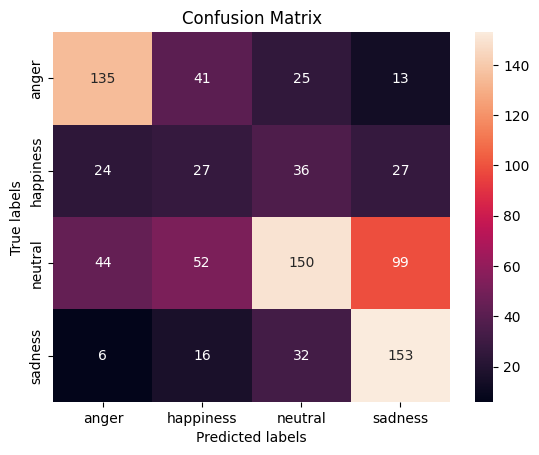


 Classification Report 
               precision    recall  f1-score   support

       anger       0.65      0.63      0.64       214
   happiness       0.20      0.24      0.22       114
     neutral       0.62      0.43      0.51       345
     sadness       0.52      0.74      0.61       207

    accuracy                           0.53       880
   macro avg       0.50      0.51      0.49       880
weighted avg       0.55      0.53      0.53       880
 

Train Epoch: 47 [0/3610 (0%)]	Loss: 1.056381

Train Epoch: 47 [640/3610 (18%)]	Loss: 1.107471

Train Epoch: 47 [1280/3610 (35%)]	Loss: 1.022393

Train Epoch: 47 [1920/3610 (53%)]	Loss: 1.103334

Train Epoch: 47 [2560/3610 (70%)]	Loss: 0.997120

Train Epoch: 47 [3200/3610 (88%)]	Loss: 1.022845


Train set: Average loss: 0.0164


Train Accuracy: 2054/3610 (57%)


Test set: Average loss: 0.0176, Accuracy: 474/880 (54%)



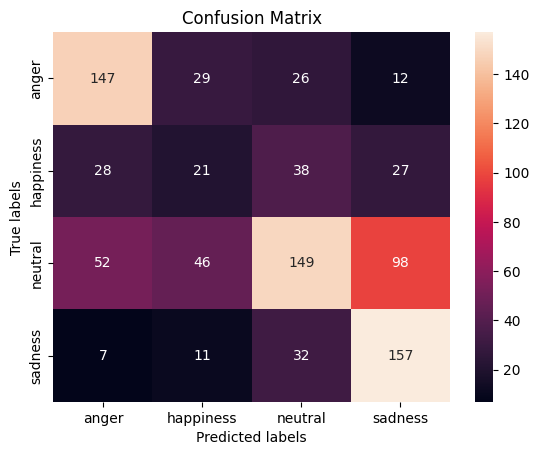


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.69      0.66       214
   happiness       0.20      0.18      0.19       114
     neutral       0.61      0.43      0.51       345
     sadness       0.53      0.76      0.63       207

    accuracy                           0.54       880
   macro avg       0.49      0.52      0.49       880
weighted avg       0.54      0.54      0.53       880
 

Train Epoch: 48 [0/3610 (0%)]	Loss: 0.848133

Train Epoch: 48 [640/3610 (18%)]	Loss: 1.199325

Train Epoch: 48 [1280/3610 (35%)]	Loss: 0.972434

Train Epoch: 48 [1920/3610 (53%)]	Loss: 1.044003

Train Epoch: 48 [2560/3610 (70%)]	Loss: 0.986324

Train Epoch: 48 [3200/3610 (88%)]	Loss: 1.153223


Train set: Average loss: 0.0163


Train Accuracy: 2055/3610 (57%)


Test set: Average loss: 0.0176, Accuracy: 467/880 (53%)



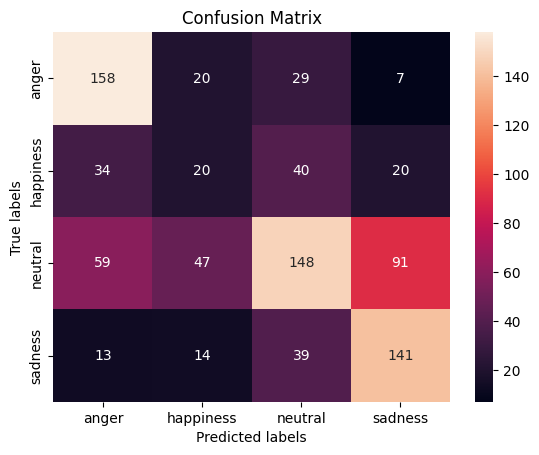


 Classification Report 
               precision    recall  f1-score   support

       anger       0.60      0.74      0.66       214
   happiness       0.20      0.18      0.19       114
     neutral       0.58      0.43      0.49       345
     sadness       0.54      0.68      0.61       207

    accuracy                           0.53       880
   macro avg       0.48      0.51      0.49       880
weighted avg       0.53      0.53      0.52       880
 

Train Epoch: 49 [0/3610 (0%)]	Loss: 1.075865

Train Epoch: 49 [640/3610 (18%)]	Loss: 1.011069

Train Epoch: 49 [1280/3610 (35%)]	Loss: 1.034535

Train Epoch: 49 [1920/3610 (53%)]	Loss: 1.106683

Train Epoch: 49 [2560/3610 (70%)]	Loss: 1.020922

Train Epoch: 49 [3200/3610 (88%)]	Loss: 1.037813


Train set: Average loss: 0.0163


Train Accuracy: 2059/3610 (57%)


Test set: Average loss: 0.0177, Accuracy: 468/880 (53%)



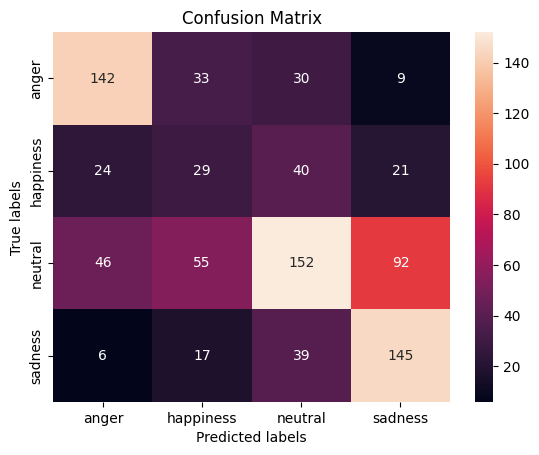


 Classification Report 
               precision    recall  f1-score   support

       anger       0.65      0.66      0.66       214
   happiness       0.22      0.25      0.23       114
     neutral       0.58      0.44      0.50       345
     sadness       0.54      0.70      0.61       207

    accuracy                           0.53       880
   macro avg       0.50      0.51      0.50       880
weighted avg       0.54      0.53      0.53       880
 

Train Epoch: 50 [0/3610 (0%)]	Loss: 1.013454

Train Epoch: 50 [640/3610 (18%)]	Loss: 1.090108

Train Epoch: 50 [1280/3610 (35%)]	Loss: 0.923282

Train Epoch: 50 [1920/3610 (53%)]	Loss: 1.057812

Train Epoch: 50 [2560/3610 (70%)]	Loss: 1.006809

Train Epoch: 50 [3200/3610 (88%)]	Loss: 0.896291


Train set: Average loss: 0.0162


Train Accuracy: 2048/3610 (57%)


Test set: Average loss: 0.0176, Accuracy: 481/880 (55%)



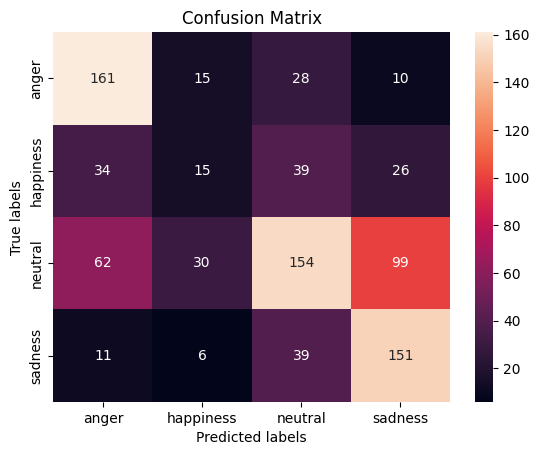


 Classification Report 
               precision    recall  f1-score   support

       anger       0.60      0.75      0.67       214
   happiness       0.23      0.13      0.17       114
     neutral       0.59      0.45      0.51       345
     sadness       0.53      0.73      0.61       207

    accuracy                           0.55       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.53      0.55      0.53       880
 



In [30]:
history = []
n_epoch = 51
for epoch in range(1, n_epoch):
#     exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
#     plateau_scheduler.step(test_loss)
    
    history.append([train_loss, train_acc, test_loss, test_acc])
    # 最后再释放一次 GPU 缓存
torch.cuda.empty_cache()

In [31]:
history_df = pd.DataFrame(history, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [32]:
history_df["epoch"] = [x for x in range(1, n_epoch)]

In [33]:
history_df

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.021792,29,0.021854,18,1
1,0.021228,34,0.020898,49,2
2,0.020802,41,0.020775,42,3
3,0.020350,42,0.020055,52,4
4,0.019944,46,0.019914,48,5
5,0.019622,47,0.019540,52,6
6,0.019289,47,0.019296,49,7
7,0.019021,48,0.018943,52,8
8,0.018780,48,0.019004,49,9
9,0.018607,50,0.018775,51,10


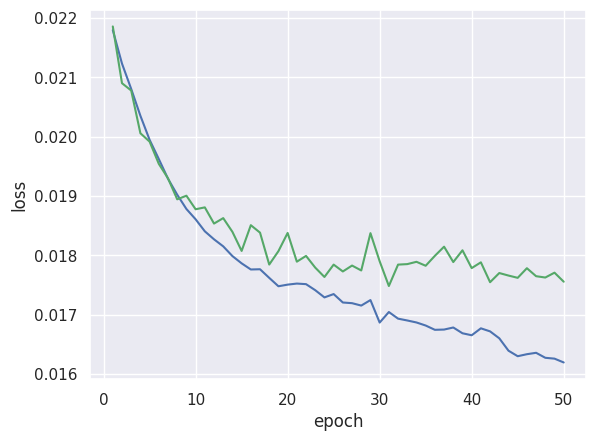

In [34]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_loss', data=history_df, color='g')
plt.ylabel("loss")
plt.show()

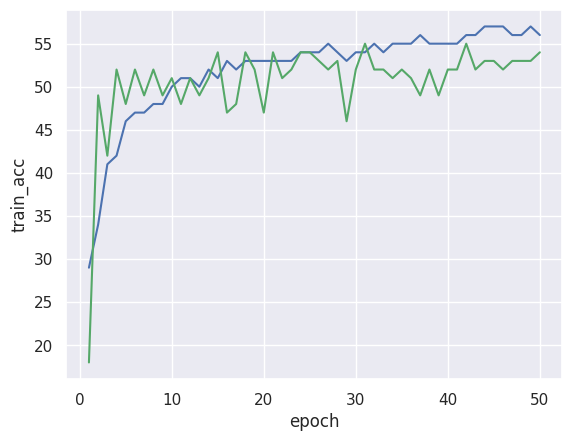

In [35]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_acc', data=history_df, color='g')
plt.show()

In [36]:
torch.save(model, model_save_path + '/ResNet50_Freeze_Weights.pth')

In [37]:
model = torch.load(model_save_path + '/ResNet50_Freeze_Weights.pth')

In [38]:
ct = 0
for child in model.children():
    ct += 1
    if ct > 7:
        print("child", ct, "was not frozen")
        for param in child.parameters():
            param.requires_grad = True
    else:
        print("child", ct, "was frozen")

child 1 was frozen
child 2 was frozen
child 3 was frozen
child 4 was frozen
child 5 was frozen
child 6 was frozen
child 7 was frozen
child 8 was not frozen
child 9 was not frozen
child 10 was not frozen


In [39]:
# for param in model.parameters():
#     param.requires_grad = True

In [40]:
# optimizer = optim.RMSprop(model.parameters(), lr=0.0003)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)
model = model.to(device)

In [41]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

58,554,412 total parameters.
15,375,340 training parameters.


In [42]:
model = model.to(device)

Train Epoch: 1 [0/3610 (0%)]	Loss: 0.958067

Train Epoch: 1 [640/3610 (18%)]	Loss: 1.088547

Train Epoch: 1 [1280/3610 (35%)]	Loss: 1.042041

Train Epoch: 1 [1920/3610 (53%)]	Loss: 0.980964

Train Epoch: 1 [2560/3610 (70%)]	Loss: 1.049025

Train Epoch: 1 [3200/3610 (88%)]	Loss: 1.074160


Train set: Average loss: 0.0162


Train Accuracy: 2095/3610 (58%)


Test set: Average loss: 0.0176, Accuracy: 463/880 (53%)



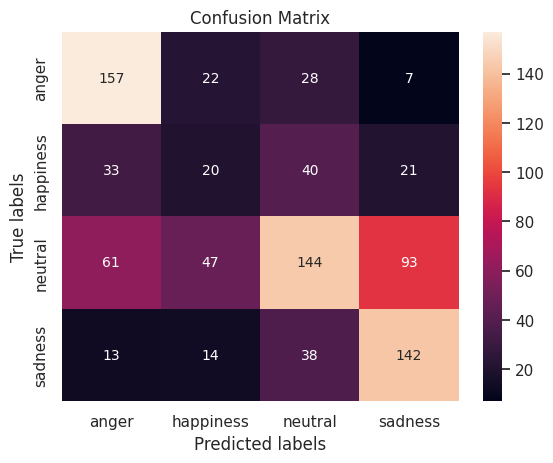


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.73      0.66       214
   happiness       0.19      0.18      0.18       114
     neutral       0.58      0.42      0.48       345
     sadness       0.54      0.69      0.60       207

    accuracy                           0.53       880
   macro avg       0.48      0.50      0.48       880
weighted avg       0.52      0.53      0.52       880
 

Train Epoch: 2 [0/3610 (0%)]	Loss: 0.920632

Train Epoch: 2 [640/3610 (18%)]	Loss: 0.885099

Train Epoch: 2 [1280/3610 (35%)]	Loss: 1.053022

Train Epoch: 2 [1920/3610 (53%)]	Loss: 1.128758

Train Epoch: 2 [2560/3610 (70%)]	Loss: 1.115164

Train Epoch: 2 [3200/3610 (88%)]	Loss: 0.881255


Train set: Average loss: 0.0161


Train Accuracy: 2031/3610 (56%)


Test set: Average loss: 0.0176, Accuracy: 463/880 (53%)



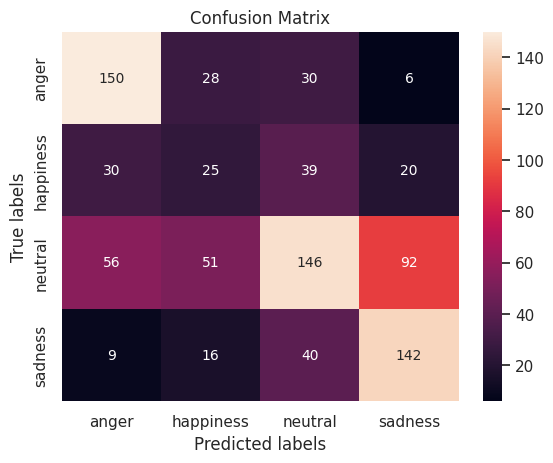


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.70      0.65       214
   happiness       0.21      0.22      0.21       114
     neutral       0.57      0.42      0.49       345
     sadness       0.55      0.69      0.61       207

    accuracy                           0.53       880
   macro avg       0.48      0.51      0.49       880
weighted avg       0.53      0.53      0.52       880
 

Train Epoch: 3 [0/3610 (0%)]	Loss: 1.040642

Train Epoch: 3 [640/3610 (18%)]	Loss: 0.919842

Train Epoch: 3 [1280/3610 (35%)]	Loss: 0.989361

Train Epoch: 3 [1920/3610 (53%)]	Loss: 1.044476

Train Epoch: 3 [2560/3610 (70%)]	Loss: 0.946799

Train Epoch: 3 [3200/3610 (88%)]	Loss: 1.167934


Train set: Average loss: 0.0160


Train Accuracy: 2093/3610 (58%)


Test set: Average loss: 0.0176, Accuracy: 465/880 (53%)



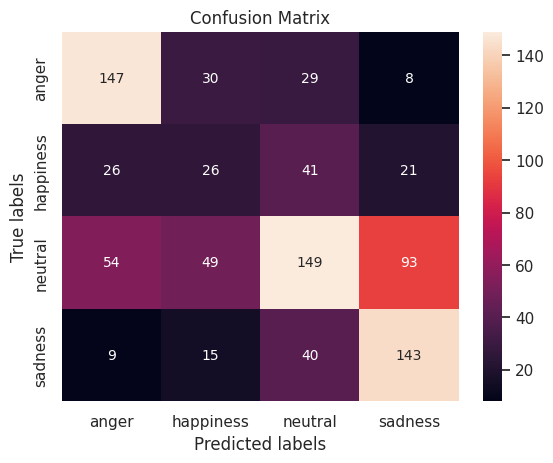


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.69      0.65       214
   happiness       0.22      0.23      0.22       114
     neutral       0.58      0.43      0.49       345
     sadness       0.54      0.69      0.61       207

    accuracy                           0.53       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.53      0.53      0.52       880
 

Train Epoch: 4 [0/3610 (0%)]	Loss: 0.891691

Train Epoch: 4 [640/3610 (18%)]	Loss: 0.998319

Train Epoch: 4 [1280/3610 (35%)]	Loss: 0.972237

Train Epoch: 4 [1920/3610 (53%)]	Loss: 0.975903

Train Epoch: 4 [2560/3610 (70%)]	Loss: 1.041052

Train Epoch: 4 [3200/3610 (88%)]	Loss: 1.048115


Train set: Average loss: 0.0159


Train Accuracy: 2113/3610 (59%)


Test set: Average loss: 0.0175, Accuracy: 472/880 (54%)



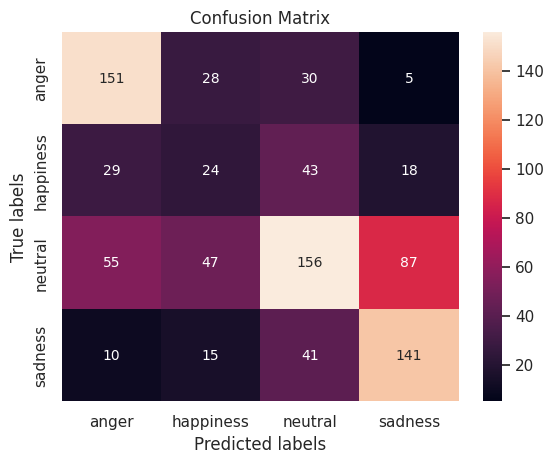


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.71      0.66       214
   happiness       0.21      0.21      0.21       114
     neutral       0.58      0.45      0.51       345
     sadness       0.56      0.68      0.62       207

    accuracy                           0.54       880
   macro avg       0.49      0.51      0.50       880
weighted avg       0.54      0.54      0.53       880
 

Train Epoch: 5 [0/3610 (0%)]	Loss: 1.013243

Train Epoch: 5 [640/3610 (18%)]	Loss: 0.910363

Train Epoch: 5 [1280/3610 (35%)]	Loss: 1.060515

Train Epoch: 5 [1920/3610 (53%)]	Loss: 1.073983

Train Epoch: 5 [2560/3610 (70%)]	Loss: 1.061457

Train Epoch: 5 [3200/3610 (88%)]	Loss: 1.018225


Train set: Average loss: 0.0158


Train Accuracy: 2112/3610 (59%)


Test set: Average loss: 0.0175, Accuracy: 467/880 (53%)



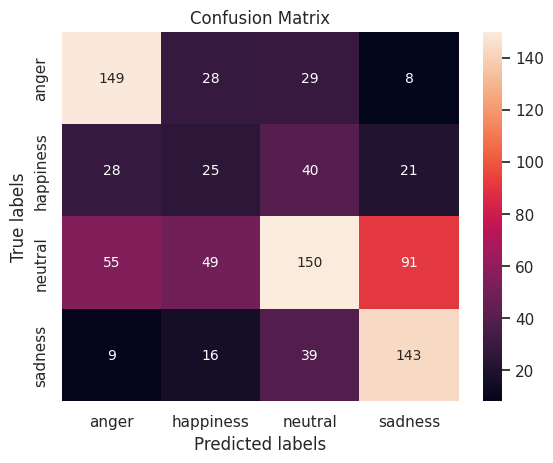


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.70      0.65       214
   happiness       0.21      0.22      0.22       114
     neutral       0.58      0.43      0.50       345
     sadness       0.54      0.69      0.61       207

    accuracy                           0.53       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.53      0.53      0.53       880
 

Train Epoch: 6 [0/3610 (0%)]	Loss: 0.934081

Train Epoch: 6 [640/3610 (18%)]	Loss: 0.910752

Train Epoch: 6 [1280/3610 (35%)]	Loss: 1.118816

Train Epoch: 6 [1920/3610 (53%)]	Loss: 0.992683

Train Epoch: 6 [2560/3610 (70%)]	Loss: 1.072561

Train Epoch: 6 [3200/3610 (88%)]	Loss: 1.018676


Train set: Average loss: 0.0156


Train Accuracy: 2162/3610 (60%)


Test set: Average loss: 0.0176, Accuracy: 463/880 (53%)



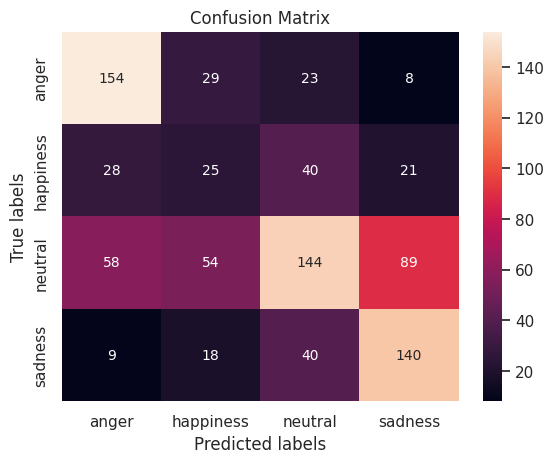


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.72      0.67       214
   happiness       0.20      0.22      0.21       114
     neutral       0.58      0.42      0.49       345
     sadness       0.54      0.68      0.60       207

    accuracy                           0.53       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.53      0.53      0.52       880
 

Train Epoch: 7 [0/3610 (0%)]	Loss: 1.030303

Train Epoch: 7 [640/3610 (18%)]	Loss: 1.001828

Train Epoch: 7 [1280/3610 (35%)]	Loss: 0.942621

Train Epoch: 7 [1920/3610 (53%)]	Loss: 1.036680

Train Epoch: 7 [2560/3610 (70%)]	Loss: 0.931712

Train Epoch: 7 [3200/3610 (88%)]	Loss: 0.938946


Train set: Average loss: 0.0157


Train Accuracy: 2130/3610 (59%)


Test set: Average loss: 0.0175, Accuracy: 469/880 (53%)



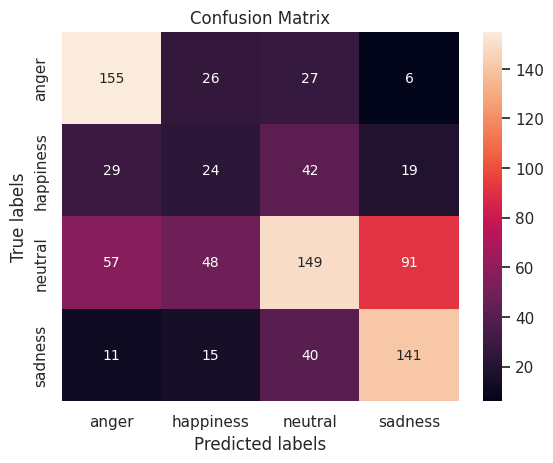


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.72      0.67       214
   happiness       0.21      0.21      0.21       114
     neutral       0.58      0.43      0.49       345
     sadness       0.55      0.68      0.61       207

    accuracy                           0.53       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.53      0.53      0.53       880
 

Train Epoch: 8 [0/3610 (0%)]	Loss: 1.123529

Train Epoch: 8 [640/3610 (18%)]	Loss: 0.941572

Train Epoch: 8 [1280/3610 (35%)]	Loss: 0.955967

Train Epoch: 8 [1920/3610 (53%)]	Loss: 0.960811

Train Epoch: 8 [2560/3610 (70%)]	Loss: 0.918412

Train Epoch: 8 [3200/3610 (88%)]	Loss: 0.946945


Train set: Average loss: 0.0156


Train Accuracy: 2143/3610 (59%)


Test set: Average loss: 0.0175, Accuracy: 466/880 (53%)



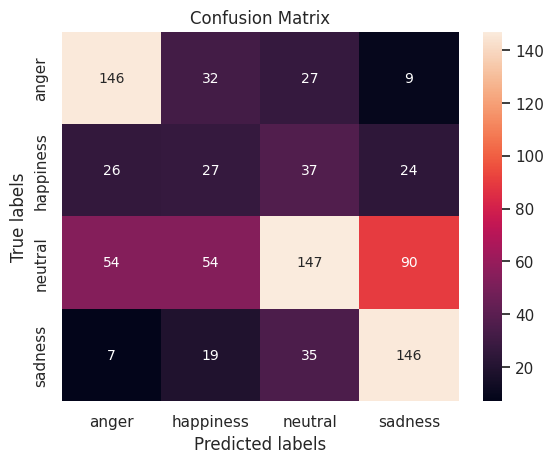


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.68      0.65       214
   happiness       0.20      0.24      0.22       114
     neutral       0.60      0.43      0.50       345
     sadness       0.54      0.71      0.61       207

    accuracy                           0.53       880
   macro avg       0.49      0.51      0.50       880
weighted avg       0.54      0.53      0.53       880
 

Train Epoch: 9 [0/3610 (0%)]	Loss: 0.906795

Train Epoch: 9 [640/3610 (18%)]	Loss: 1.018000

Train Epoch: 9 [1280/3610 (35%)]	Loss: 0.910630

Train Epoch: 9 [1920/3610 (53%)]	Loss: 0.901017

Train Epoch: 9 [2560/3610 (70%)]	Loss: 0.984771

Train Epoch: 9 [3200/3610 (88%)]	Loss: 0.918157


Train set: Average loss: 0.0155


Train Accuracy: 2189/3610 (61%)


Test set: Average loss: 0.0175, Accuracy: 468/880 (53%)



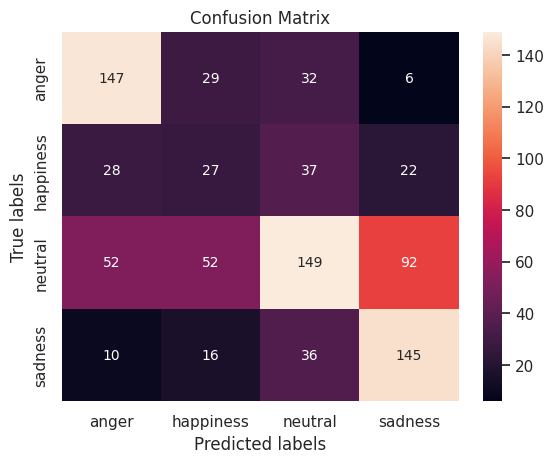


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.69      0.65       214
   happiness       0.22      0.24      0.23       114
     neutral       0.59      0.43      0.50       345
     sadness       0.55      0.70      0.61       207

    accuracy                           0.53       880
   macro avg       0.49      0.51      0.50       880
weighted avg       0.54      0.53      0.53       880
 

Train Epoch: 10 [0/3610 (0%)]	Loss: 1.158113

Train Epoch: 10 [640/3610 (18%)]	Loss: 0.963686

Train Epoch: 10 [1280/3610 (35%)]	Loss: 1.063797

Train Epoch: 10 [1920/3610 (53%)]	Loss: 0.949623

Train Epoch: 10 [2560/3610 (70%)]	Loss: 0.994669

Train Epoch: 10 [3200/3610 (88%)]	Loss: 0.943977


Train set: Average loss: 0.0154


Train Accuracy: 2143/3610 (59%)


Test set: Average loss: 0.0176, Accuracy: 469/880 (53%)



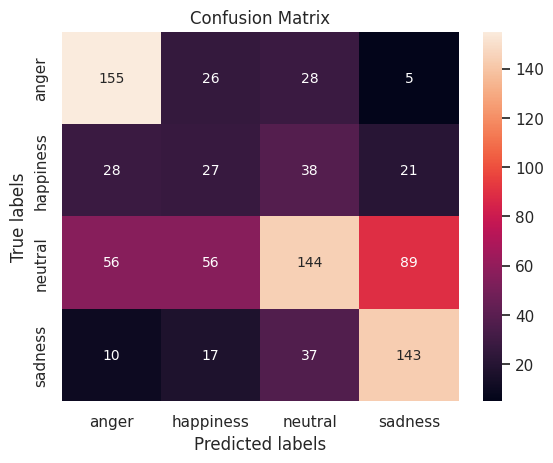


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.72      0.67       214
   happiness       0.21      0.24      0.23       114
     neutral       0.58      0.42      0.49       345
     sadness       0.55      0.69      0.62       207

    accuracy                           0.53       880
   macro avg       0.49      0.52      0.50       880
weighted avg       0.54      0.53      0.53       880
 



In [43]:
history_unfreeze = []
n_epoch_unfrz = 11
for epoch in range(1, n_epoch_unfrz):
#     exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
    history_unfreeze.append([train_loss, train_acc, test_loss, test_acc])

In [44]:
history_df_unfrz = pd.DataFrame(history_unfreeze, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [45]:
history_df_unfrz["epoch"] = [x for x in range(n_epoch, n_epoch + n_epoch_unfrz - 1)]

In [46]:
history_df_unfrz

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.016239,58,0.017647,52,51
1,0.016114,56,0.017641,52,52
2,0.015953,57,0.017563,52,53
3,0.015891,58,0.017519,53,54
4,0.015843,58,0.017541,53,55
5,0.015645,59,0.017588,52,56
6,0.015689,59,0.017523,53,57
7,0.015562,59,0.017542,52,58
8,0.015450,60,0.017532,53,59
9,0.015425,59,0.017553,53,60


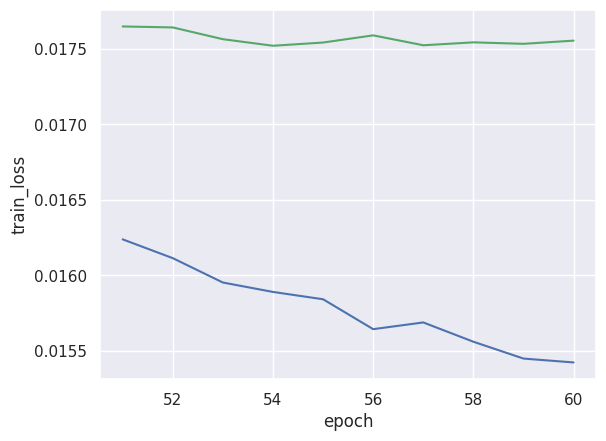

In [47]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df_unfrz, color='b')
sns.lineplot(x='epoch', y='test_loss', data=history_df_unfrz, color='g')
plt.show()
# plt.xticks()

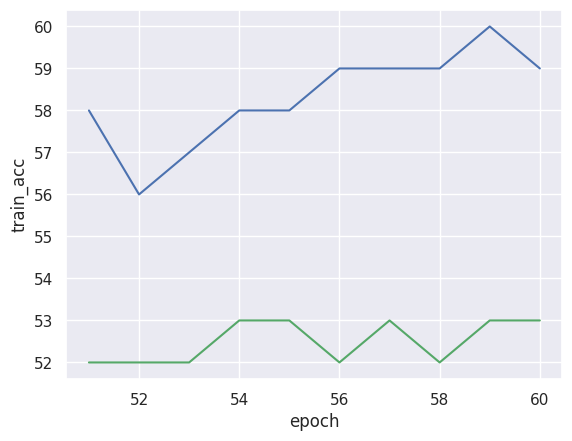

In [48]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df_unfrz, color='b')
sns.lineplot(x='epoch', y='test_acc', data=history_df_unfrz, color='g')
plt.show()
# plt.xticks()

In [49]:
torch.save(model, model_save_path + '/ResNet152_UnFreeze_Weights.pth')

In [50]:
history_total = pd.concat([history_df, history_df_unfrz])

In [51]:
history_total

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.021792,29,0.021854,18,1
1,0.021228,34,0.020898,49,2
2,0.020802,41,0.020775,42,3
3,0.020350,42,0.020055,52,4
4,0.019944,46,0.019914,48,5
5,0.019622,47,0.019540,52,6
6,0.019289,47,0.019296,49,7
7,0.019021,48,0.018943,52,8
8,0.018780,48,0.019004,49,9
9,0.018607,50,0.018775,51,10


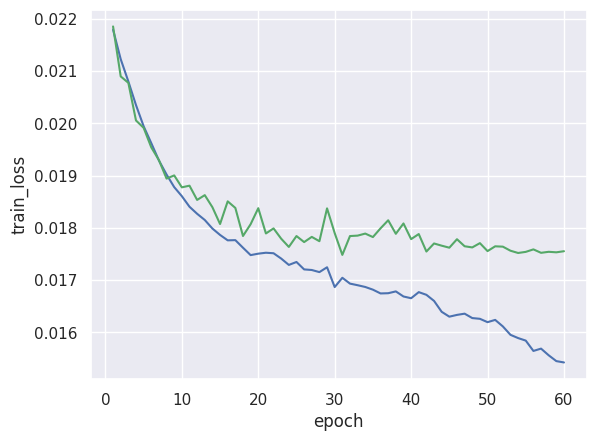

In [52]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_total, color='b')
sns.lineplot(x='epoch', y='test_loss', data=history_total, color='g')
plt.show()
# plt.xticks()

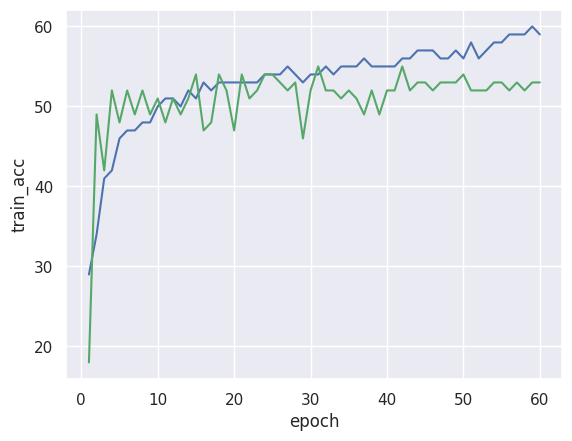

In [53]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_total, color='b')
sns.lineplot(x='epoch', y='test_acc', data=history_total, color='g')
plt.show()
# plt.xticks()

Experiment with SGD

In [54]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
model = model.to(device)

In [55]:
for param in model.parameters():
    param.requires_grad = True

In [56]:
history_unfreeze_full = []
n_epoch_unfrz_full = 11
for epoch in range(1, n_epoch_unfrz_full):
#     exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
    history_unfreeze_full.append([train_loss, train_acc, test_loss, test_acc])

Train Epoch: 1 [0/3610 (0%)]	Loss: 0.909114

Train Epoch: 1 [640/3610 (18%)]	Loss: 0.958231

Train Epoch: 1 [1280/3610 (35%)]	Loss: 0.965265

Train Epoch: 1 [1920/3610 (53%)]	Loss: 0.940451

Train Epoch: 1 [2560/3610 (70%)]	Loss: 1.012455

Train Epoch: 1 [3200/3610 (88%)]	Loss: 0.933516


Train set: Average loss: 0.0154


Train Accuracy: 2152/3610 (60%)



OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 0 has a total capacity of 23.64 GiB of which 4.12 MiB is free. Process 803687 has 2.46 GiB memory in use. Process 980381 has 21.17 GiB memory in use. Of the allocated memory 20.10 GiB is allocated by PyTorch, and 617.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
history_df_unfrz_full = pd.DataFrame(history_unfreeze_full, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [ ]:
history_df_unfrz_full["epoch"] = [x for x in range(n_epoch_unfrz, n_epoch_unfrz + n_epoch_unfrz_full - 1)]

In [ ]:
history_df_unfrz_full

In [ ]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df_unfrz_full, color='b')
sns.lineplot(x='epoch', y='test_loss', data=history_df_unfrz_full, color='g')
plt.show()
# plt.xticks()

In [ ]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df_unfrz_full, color='b')
sns.lineplot(x='epoch', y='test_acc', data=history_df_unfrz_full, color='g')
plt.show()
# plt.xticks()